In [ ]:
import pandas as pd
pd.set_option("max_colwidth", 400)
pd.set_option("display.max.columns", None)

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
plt.style.use("seaborn-talk")


In [ ]:
def load_data(file_path, indx = True, indx_col = 0):
  '''Parameters:
  file_path: path to your excel or csv file with data,
  indx: boolean - whether there is index column in your file (usually it is the first column) --> *by default it is set to True
  indx_col: int - if your file has an index column, specify column number here --> *by default it is equal to 0 (first column)
  '''
  if indx == True and file_path.endswith(".xlsx"):
    data = pd.read_excel(file_path, index_col = indx_col)
  elif indx == False and file_path.endswith(".xlsx"):
    data = pd.read_excel(file_path)

  elif indx == True and file_path.endswith(".csv"):
    data = pd.read_csv(file_path, index_col = indx_col)
  elif indx == False and file_path.endswith(".csv"):
    data = pd.read_csv(file_path)

  return data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#ITC corpus retrieve data

In [ ]:
maps = glob.glob("/content/drive/MyDrive/Colab Notebooks/debates/us2016itc/*.json")


def conclusionPremiseDict(premises, conclusions):
    pairs = {}
    for i, x in enumerate(conclusions):
        pairs[i] = {'conclusion':x, 'premises':[]}
        id_to = x['fromID']
        for p in premises:
            if p['toID'] == id_to:
                pairs[i]['premises'].append(p)                
    return pairs

def aduPairs(edgePairs, nodesById):
    aduPair = []
    for pair in edgePairs.values():
        for p in pair['premises']:
          aduPair.append([nodesById[pair['conclusion']['toID']]['text'], nodesById[p['fromID']]['text']])    
    return aduPair

def pairs(map):
    with open(map) as f:
        data = json.loads(f.read())
    nodesById = {}
    for _, node in enumerate(data['nodes']):
        nodesById[node['nodeID']] = node
        
    premises = [x for x in data['edges'] if nodesById[x['fromID']]['type'] == 'I' and nodesById[x['toID']]['type'] == 'MA']

    conclusions = [x for x in data['edges'] if nodesById[x['fromID']]['type'] == 'MA' and nodesById[x['toID']]['type'] == 'I']
    edgePairs = conclusionPremiseDict(premises, conclusions)
    adus = aduPairs(edgePairs, nodesById)
    return adus, conclusions, premises, nodesById    

truePairs = []
conclusions = []
premises = []
nodesById = {}

truePairs = []
conclusions = []
premises = []
nodesById = {}

map_number = []

for i, m in enumerate(maps):
    adus, c, p, n = pairs(m)
    truePairs.extend(adus)
    conclusions.extend(c)
    premises.extend(p)
    nodesById = {**nodesById, **n}
    for num in range(len(adus)):
      map_number.append(maps[i][-10:-5])



In [ ]:
data = pd.DataFrame(truePairs)
data.columns = ["conclusion", "premises"]
data["map_ID"] = map_number


In [ ]:
layers = load_data("/content/drive/MyDrive/Colab Notebooks/reddit_IAA/REDDIT_PATHOS_ETHOS_LOGOS_all.xlsx")

In [ ]:
premises_t = data.premises.unique()
conclusion_t = data.conclusion.unique()


cid = []
pid = []
tt1 = layers['original_Text'].tolist()
tt2 = layers['text_I_left'].tolist()
for i, t in enumerate(conclusion_t):
  if (t in tt1) or (t in tt2):
    cid.append(t)

for i, t in enumerate(premises_t):
  if (t in tt1) or (t in tt2):
    pid.append(t)  


cid = [c.lower() for c in cid]
pid = [c.lower() for c in pid]

In [ ]:
data['type_match'] = "" # whether social media text is a conclusion or a premise in an argument in the ITC corpus
data['c_match'] = "" # if is is matched on conclusion, text of a social media text
data['p_match'] = "" # if is is matched on premise, text of a social media text


for t in cid:
    for i in data.index:
      if data.loc[i, 'conclusion'].lower() == t:
        data.loc[i]['type_match'] = 'conclusion reddit'
        data.loc[i]['c_match'] = t


for t in pid:
  for i in data.index:
    if t in data.loc[i, 'premises'].lower():
      data.loc[i]['type_match'] = 'premise reddit'
      data.loc[i]['p_match'] = t



In [ ]:
data.to_excel("/content/drive/MyDrive/Colab Notebooks/debates/us2016itc/file_itc.xlsx")

#Add debate - politicians arguments text

In [ ]:
import json
import glob

d = glob.glob("/content/drive/MyDrive/Colab Notebooks/debates/US2016D1/*.json")
r = glob.glob("/content/drive/MyDrive/Colab Notebooks/debates/US2016R1/*.json")
g = glob.glob("/content/drive/MyDrive/Colab Notebooks/debates/US2016G1/*.json")

maps = d + r + g


def conclusionPremiseDict(premises, conclusions):
    pairs = {}
    for i, x in enumerate(conclusions):
        pairs[i] = {'conclusion':x, 'premises':[]}
        id_to = x['fromID']
        for p in premises:
            if p['toID'] == id_to:
                pairs[i]['premises'].append(p)                
    return pairs


def aduPairs(edgePairs, nodesById):
    nodeid_list = []
    conc_id = []
    for pair in edgePairs.values():        
        conc_id.append(str(nodesById[pair['conclusion']['toID']]['text']))

    conc_id = set(conc_id)
    for cid in conc_id:
      premises_all = []
      for pair in edgePairs.values():
        if cid == str(nodesById[pair['conclusion']['toID']]['text']):
          for p in pair['premises']:
            premises_all.append(str(nodesById[p['fromID']]['text']))
      if len(premises_all) != 0:
        nodeid_list.append([cid, premises_all])
    return nodeid_list



def pairs(map):
    with open(map) as f:
        data = json.loads(f.read())
    nodesById = {}
    for _, node in enumerate(data['nodes']):
        nodesById[node['nodeID']] = node
        
    premises = [x for x in data['edges'] if nodesById[x['fromID']]['type'] == 'I' and nodesById[x['toID']]['type'] == 'RA']

    conclusions = [x for x in data['edges'] if nodesById[x['fromID']]['type'] == 'RA' and nodesById[x['toID']]['type'] == 'I']
    edgePairs = conclusionPremiseDict(premises, conclusions)
    adus = aduPairs(edgePairs, nodesById)
    return adus, conclusions, premises, nodesById 



truePairs = []
conclusions = []
premises = []
nodesById = {}

map_number = []

for i, m in enumerate(maps):
    adus, c, p, n = pairs(m)
    truePairs.extend(adus)
    conclusions.extend(c)
    premises.extend(p)
    nodesById = {**nodesById, **n}
    for num in range(len(adus)):
      map_number.append(maps[i][-10:-5])    



# premises are returned in list, but they can easily be joined (here they are joined by " --- ", for example)
# conclusions are in a standard text format

df_text = pd.DataFrame(truePairs)
df_text.columns = ["conclusion", "premises"]
df_text['premises'] = df_text['premises'].apply(lambda x: " --- ".join(x))
df_text["map_ID"] = map_number
print(df_text.shape)
df_text.tail()

(1107, 3)


,conclusion,premises,map_ID
1102,CLINTON sure hopes people will get out and vote as though their future depended on it,people's future does depend on the election,11321
1103,perhaps it was worse than pressing the wrong button,perhaps it was corruption,11321
1104,perhaps it was corruption,these people that we were going to deport for good reason ended up becoming citizens,11321
1105,people are pouring into the USA,the other day USA were deporting 800 people,11321
1106,CLINTON certainly will support the outcome of this election,CLINTON supports USA's democracy,11321


In [ ]:
ids_match_itc = []
ids_match_corp_deb = []
str_match = []

for i1 in data.index:
  for i2 in df_text.index:
    if data.loc[i1, 'debate_claim'] in df_text.loc[i2, 'conclusion']:
      ids_match_itc.append(i1)
      ids_match_corp_deb.append(i2)
      str_match.append('conclusion')
    elif data.loc[i1, 'debate_claim'] in df_text.loc[i2, 'premises']:
      ids_match_itc.append(i1)
      ids_match_corp_deb.append(i2)
      str_match.append('premises')


In [ ]:
deb = np.concatenate([df_text.loc[ids_match_corp_deb], data.loc[ids_match_itc], pd.DataFrame(str_match, columns=['match_on'])], axis = 1)
deb = pd.DataFrame(deb, columns = list(df_text.columns)+list(data.columns)+['match_on'])

deb.drop_duplicates(['debate_claim','text_reddit'], inplace=True)

In [ ]:
deb.debate_claim.nunique()

68

In [ ]:
deb.reset_index(inplace=True, drop=True)

In [ ]:
deb['debate_match'] = '' # whether a politician claim in a conclusion or a premise in ITC 
deb['debate_claim'] = '' # text of a politician claim 


for i2 in deb.index:
    if deb.loc[i2, 'type_match'] == 'premise reddit':
      deb.loc[i2, 'debate_match'] = 'conclusion deb'
      deb.loc[i2, 'debate_claim'] = deb.loc[i2, 'conclusion']
    
    elif deb.loc[i2, 'type_match'] == 'conclusion reddit':
      deb.loc[i2, 'debate_match'] = 'premise deb'
      deb.loc[i2, 'debate_claim'] = deb.loc[i2, 'premises']



##Add multi-layers annotation

In [ ]:
df = load_data("/content/drive/MyDrive/Colab Notebooks/debates/us2016itc/file_itc.xlsx")

In [ ]:
df['conclusion'] = df['conclusion'].str.lower()
df['premises'] = df['premises'].str.lower()

In [ ]:
# merge LEP annotation with itc corpus

df1 = pd.merge(df, layers, left_on = 'p_match', right_on='text_I', how = 'inner') 
print(df1.shape)
df1.dropna(subset=['p_match', 'text_I'], axis=0, inplace=True)


df2 = pd.merge(df, layers, left_on = 'c_match', right_on='text_I', how = 'inner')
df2.dropna(subset=['c_match', 'text_I'], axis=0, inplace=True)
print(df2.shape)


df3 = pd.merge(df, layers, left_on = 'p_match', right_on='Text_pat', how = 'inner')
df3.dropna(subset=['p_match', 'Text_pat'], axis=0, inplace=True)
print(df3.shape)


df4 = pd.merge(df, layers, left_on = 'c_match', right_on='Text_pat', how = 'inner')
df4.dropna(subset=['c_match', 'Text_pat'], axis=0, inplace=True)


In [ ]:
df = pd.concat([df1, df2, df3, df4], axis = 0)

In [ ]:
df.drop_duplicates(['Text_pat', 'Num_pat', 'premises'], inplace=True)
df.sort_values(by = 'Num_pat', inplace=True)

#Add Reddit comments

In [ ]:
layers.shape

(4263, 51)

In [ ]:
df_num = df.Num_pat.tolist()
df_num = set(df_num)
len(df_num)

151

In [ ]:
et_num = layers.Num_pat.tolist()
et_num = set(et_num)
len(et_num)

4263

In [ ]:
add_redit = []

for n in df_num:
  new_up = [n + i for i in range(10)] # add ids of the following 10 comments in the data
  add_redit.extend(new_up)

len(add_redit)

1510

In [ ]:
new_redit = set(add_redit).intersection(et_num) # check whether those ids are indeed in the data
len(new_redit)

1198

In [ ]:
new_redit = [i for i in new_redit if i not in df_num]
len(new_redit)

1047

In [ ]:
add_et = layers[layers.Num_pat.isin(new_redit)]
add_et.shape

(1047, 51)

In [ ]:
col_et = [c for c in layers.columns if c in df.columns]
len(col_et), len(layers.columns)

(46, 51)

In [ ]:
add_et = add_et[col_et]
add_et.shape

(1047, 46)

In [ ]:
col = [c for c in df.columns if c not in add_et.columns]

In [ ]:
for c in col:
  add_et[c] = np.nan

add_et.shape

(1047, 57)

In [ ]:
df.shape

(152, 57)

In [ ]:
add_et = add_et[df.columns]
add_et

In [ ]:
# add those new comments to the retrieved itc corpus

df_add = pd.concat([df, add_et], axis = 0)
df_add.sort_values(by = 'Num_pat', inplace=True)
df_add.reset_index(inplace=True, drop = True)
df_add.head()

In [ ]:
df_add.shape

(1199, 57)

In [ ]:
df_add[['debate_match', 'debate_claim']] = df_add[['debate_match', 'debate_claim']].fillna(method = 'ffill', limit = 10)

In [ ]:
df_add.to_excel("/content/drive/MyDrive/Colab Notebooks/debates/us2016itc/itc_US_processed_debate_arg_only.xlsx")

#Results

##Expressed emotios stats

In [ ]:
merged = load_data('/content/drive/MyDrive/Colab Notebooks/debates/us2016itc/itc_US_processed_debate_arg_only.xlsx')
merged = merged[merged.debate != 'D1']
merged.shape

(482, 116)

In [ ]:
merged.head(1)

,Num,debate,map_ID,debate_claim,conclusion,premises,text_reddit,timestamp,Node_id,nodeset_id,clean_text_reddit,recognized_emotion,recognised_sentiment,conclusion_lemmatized,conclusion_emotive_words,conclusion_joy,conclusion_anger,conclusion_sadness,conclusion_fear,conclusion_disgust,conclusion_surprise,conclusion_trust,conclusion_anticipation,conclusion_joy_individual,conclusion_anger_individual,conclusion_sadness_individual,conclusion_fear_individual,conclusion_disgust_individual,conclusion_surprise_individual,conclusion_trust_individual,conclusion_anticipation_individual,conclusion_emotion_categories_NRC,premises_lemmatized,premises_emotive_words,premises_joy,premises_anger,premises_sadness,premises_fear,premises_disgust,premises_surprise,premises_trust,premises_anticipation,premises_joy_individual,premises_anger_individual,premises_sadness_individual,premises_fear_individual,premises_disgust_individual,premises_surprise_individual,premises_trust_individual,premises_anticipation_individual,premises_emotion_categories_NRC,CATEGORY_premises_anger,CATEGORY_premises_disgust,CATEGORY_premises_fear,CATEGORY_premises_negative,CATEGORY_premises_sadness,CATEGORY_premises_trust,CATEGORY_premises_anticipation,CATEGORY_premises_surprise,CATEGORY_premises_joy,CATEGORY_premises_positive,premises_valence_words,premises_valence_negative,premises_valence_positive,premises_Negative_percentage,premises_Positive_percentage,full_argument,full_argument_lemmatized,full_argument_emotive_words,full_argument_joy,full_argument_anger,full_argument_sadness,full_argument_fear,full_argument_disgust,full_argument_surprise,full_argument_trust,full_argument_anticipation,full_argument_joy_individual,full_argument_anger_individual,full_argument_sadness_individual,full_argument_fear_individual,full_argument_disgust_individual,full_argument_surprise_individual,full_argument_trust_individual,full_argument_anticipation_individual,full_argument_emotion_categories_NRC,CATEGORY_full_argument_joy,CATEGORY_full_argument_positive,CATEGORY_full_argument_trust,CATEGORY_full_argument_anger,CATEGORY_full_argument_disgust,CATEGORY_full_argument_fear,CATEGORY_full_argument_negative,CATEGORY_full_argument_sadness,CATEGORY_full_argument_anticipation,CATEGORY_full_argument_surprise,full_argument_valence_words,full_argument_valence_negative,full_argument_valence_positive,full_argument_Negative_percentage,full_argument_Positive_percentage,CATEGORY_conclusion_trust,CATEGORY_conclusion_fear,CATEGORY_conclusion_negative,CATEGORY_conclusion_sadness,CATEGORY_conclusion_anger,CATEGORY_conclusion_surprise,CATEGORY_conclusion_positive,CATEGORY_conclusion_disgust,CATEGORY_conclusion_joy,CATEGORY_conclusion_anticipation,conclusion_valence_words,conclusion_valence_negative,conclusion_valence_positive,conclusion_Negative_percentage,conclusion_Positive_percentage
225.0,1552.0,R1,10828.0,"in florida, they called bush jeb","in florida, they called bush jeb",bush earned it,They call me Jeb,2016-10-07 16:09:00,204623.0,10303.0,they call me jeb,surprise,Negative,"['in', 'florida', '-PRON-', 'call', 'bush', 'jeb']",[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],[],[],[],[],[],[],[],"['bush', 'earn', '-PRON-']",['earn'],0.0,0.0,0.0,0.0,0.0,0.0,0.562,0.0,[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.562],[0.0],['positive'],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,['earn'],0.0,1.0,0.0,0.333,"in florida, they called bush jeb bush earned it","['in', 'florida', '-PRON-', 'call', 'bush', 'jeb', 'bush', 'earn', '-PRON-']",['earn'],0.0,0.0,0.0,0.0,0.0,0.0,0.562,0.0,[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.562],[0.0],['positive'],0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,['earn'],0.0,1.0,0.0,0.111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[],0.0,0.0,0.0,0.0


In [ ]:
merged.recognized_emotion.value_counts(normalize=True).round(4)*100

surprise    68.67
anger       13.49
joy         12.24
sadness      3.73
fear         1.45
disgust      0.41
Name: recognized_emotion, dtype: float64

In [ ]:
merged.recognised_sentiment.value_counts(normalize=True).round(4)*100

Negative    56.02
Neutral     36.10
Positive     7.88
Name: recognised_sentiment, dtype: float64

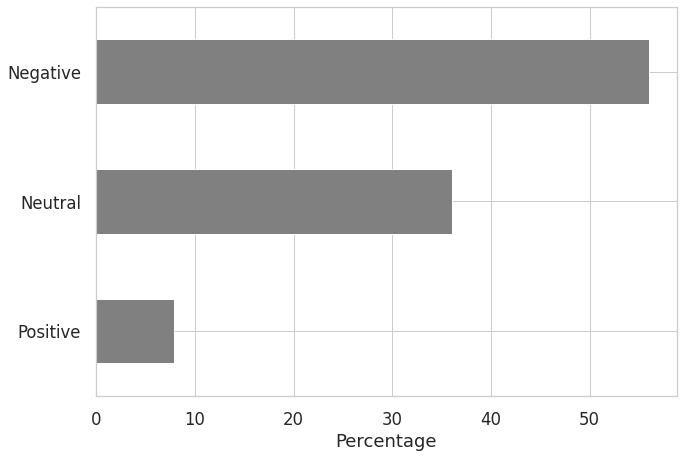

In [ ]:
sns.set(font_scale=1.5, style='whitegrid')
pd.DataFrame(merged.recognised_sentiment.value_counts(normalize=True).round(4)*100).sort_values(by = 'recognised_sentiment').plot(kind='barh', 
                                                                                                                          color='grey', 
                                                                                                                          legend=False)
plt.xlabel('Percentage')
plt.show()

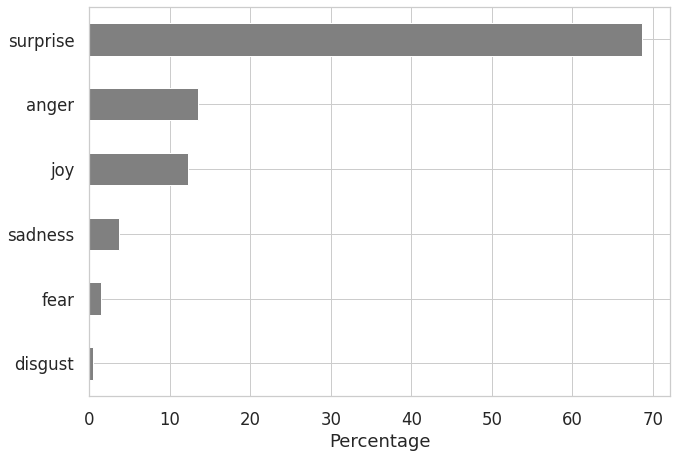

In [ ]:
sns.set(font_scale=1.5, style='whitegrid')
pd.DataFrame(merged.recognized_emotion.value_counts(normalize=True).round(4)*100).sort_values(by = 'recognized_emotion').plot(kind='barh', 
                                                                                                                          color='grey', 
                                                                                                                          legend=False)
plt.xlabel('Percentage')
plt.show()

In [ ]:
sm1 = load_data("/content/drive/MyDrive/Colab Notebooks/debates/validation_samples/tweet_May_expressed_sentiment.xlsx")
sm1.sort_values(by = 'Data', inplace=True)
sm1.shape

(19073, 12)

In [ ]:
sm1.head(1)

,Data,Tekst,clean_Tekst,predicted_emotion_PaREMO,predicted_emotion_label_PaREMO,sentiment_PaRes,sentiment_label_PaRes,predicted_emotion_XLM_tuned,predicted_emotion_label_XLM_tuned,predicted_emotion_PaREMO_2,predicted_emotion_label_PaREMO_2,expressed_emotion_PaREMO
17639.0,2020-05-06 20:30:05,@napalonywikary W wigilie,@user W wigilie,4.0,joy,1.0,neu,0.0,neutral,3.0,fear,neutral


In [ ]:
sm2 = load_data("/content/drive/MyDrive/Colab Notebooks/debates/validation_samples/tweet_Czerwiec_expressed_sentiment.xlsx")
sm2.sort_values(by = 'Data', inplace=True)

In [ ]:
sm2.sample(1)

,Data,Tekst,clean_Tekst,predicted_emotion_PaREMO,predicted_emotion_label_PaREMO,sentiment_PaRes,sentiment_label_PaRes,predicted_emotion_XLM_tuned,predicted_emotion_label_XLM_tuned,predicted_emotion_PaREMO_2,predicted_emotion_label_PaREMO_2
63172.0,2020-06-17 21:43:24,Pytania to porazka. Nic ciekawego.. Szkoda. #DebataPrezydencka,pytania to porazka. nic ciekawego.. szkoda.,5.0,sadness,0.0,neg,2.0,disgust,5.0,sadness


In [ ]:
sm1 = sm1[ (sm1.Data >= '2020-05-06 20:34:00') & (sm1.Data <= '2020-05-06 21:42:00') ]
sm2 = sm2[ (sm2.Data >= '2020-06-17 21:03:00') & (sm2.Data <= '2020-06-17 22:18:00') ]
sm2.shape, sm1.shape

((21948, 11), (12262, 12))

In [ ]:
len(" ".join(sm1['Tekst'].values).split())

150504

In [ ]:
len(" ".join(sm2['Tekst'].values).split())

270755

In [ ]:
smpl = pd.concat( [sm1[['predicted_emotion_label_PaREMO']], sm2[['predicted_emotion_label_PaREMO']]], axis=0, ignore_index=True )
smpl['predicted_emotion_label_PaREMO'].value_counts(normalize=True).round(4)*100

surprise    46.49
anger       22.52
sadness     11.77
joy         11.09
fear         7.92
disgust      0.21
Name: predicted_emotion_label_PaREMO, dtype: float64

In [ ]:
smpl.columns = ['recognized_emotion']

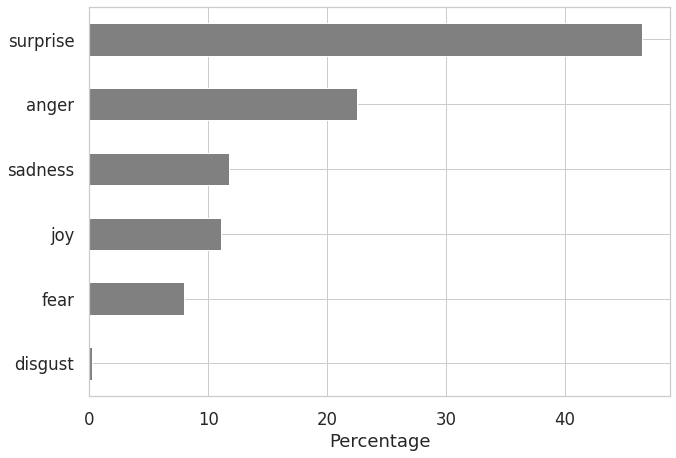

In [ ]:
sns.set(font_scale=1.5, style='whitegrid')
pd.DataFrame(smpl.predicted_emotion_label_PaREMO.value_counts(normalize=True).round(4)*100).sort_values(by = 'predicted_emotion_label_PaREMO').plot(kind='barh', 
                                                                                                                          color='grey', 
                                                                                                                          legend=False)
plt.xlabel('Percentage')
plt.show()

In [ ]:
smpl = pd.concat( [sm1[['sentiment_label_PaRes']], sm2[['sentiment_label_PaRes']]], axis=0, ignore_index=True )
smpl.columns = ['recognised_sentiment']
smpl['recognised_sentiment'].value_counts(normalize=True).round(4)*100

neg    60.03
pos    20.36
neu    19.61
Name: recognised_sentiment, dtype: float64

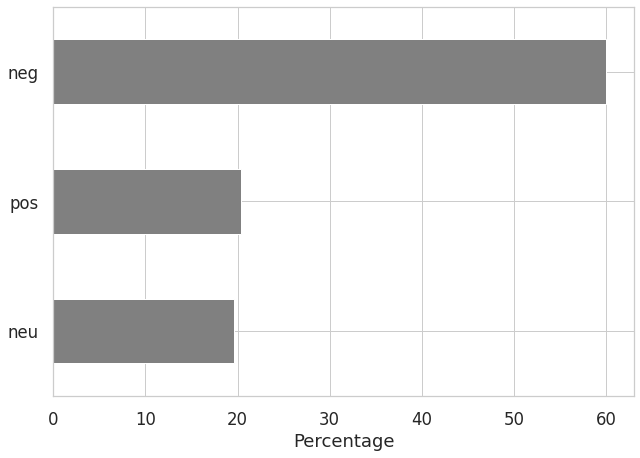

In [ ]:
sns.set(font_scale=1.5, style='whitegrid')
pd.DataFrame(smpl.recognised_sentiment.value_counts(normalize=True).round(4)*100).sort_values(by = 'recognised_sentiment').plot(kind='barh', 
                                                                                                                          color='grey', 
                                                                                                                          legend=False)
plt.xlabel('Percentage')
plt.show()

In [ ]:
sm = pd.concat( [smpl,  merged[['recognized_emotion']]], axis=0, ignore_index=True )
sm['recognized_emotion'] = sm['recognized_emotion'].str.capitalize()
sm.recognized_emotion.value_counts(normalize=True).round(4)*100

Surprise    68.67
Anger       13.49
Joy         12.24
Sadness      3.73
Fear         1.45
Disgust      0.41
Name: recognized_emotion, dtype: float64

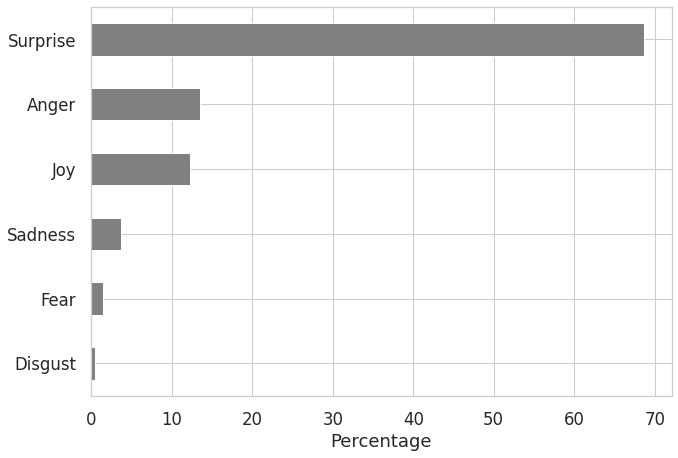

In [ ]:
sns.set(font_scale=1.5, style='whitegrid')
pd.DataFrame(sm.recognized_emotion.value_counts(normalize=True).round(4)*100).sort_values(by = 'recognized_emotion').plot(kind='barh', 
                                                                                                                          color='grey', 
                                                                                                                          legend=False)
plt.xlabel('Percentage')
plt.show()

##Preprocess

In [ ]:
merged = load_data('/content/drive/MyDrive/Colab Notebooks/debates/us2016itc/itc_US_processed_debate_arg_only.xlsx')
merged.shape

(707, 116)

In [ ]:
merged.tail(1)

,Num,debate,map_ID,debate_claim,conclusion,premises,text_reddit,timestamp,Node_id,nodeset_id,clean_text_reddit,recognized_emotion,recognised_sentiment,conclusion_lemmatized,conclusion_emotive_words,conclusion_joy,conclusion_anger,conclusion_sadness,conclusion_fear,conclusion_disgust,conclusion_surprise,conclusion_trust,conclusion_anticipation,conclusion_joy_individual,conclusion_anger_individual,conclusion_sadness_individual,conclusion_fear_individual,conclusion_disgust_individual,conclusion_surprise_individual,conclusion_trust_individual,conclusion_anticipation_individual,conclusion_emotion_categories_NRC,premises_lemmatized,premises_emotive_words,premises_joy,premises_anger,premises_sadness,premises_fear,premises_disgust,premises_surprise,premises_trust,premises_anticipation,premises_joy_individual,premises_anger_individual,premises_sadness_individual,premises_fear_individual,premises_disgust_individual,premises_surprise_individual,premises_trust_individual,premises_anticipation_individual,premises_emotion_categories_NRC,CATEGORY_premises_anger,CATEGORY_premises_disgust,CATEGORY_premises_fear,CATEGORY_premises_negative,CATEGORY_premises_sadness,CATEGORY_premises_trust,CATEGORY_premises_anticipation,CATEGORY_premises_surprise,CATEGORY_premises_joy,CATEGORY_premises_positive,premises_valence_words,premises_valence_negative,premises_valence_positive,premises_Negative_percentage,premises_Positive_percentage,full_argument,full_argument_lemmatized,full_argument_emotive_words,full_argument_joy,full_argument_anger,full_argument_sadness,full_argument_fear,full_argument_disgust,full_argument_surprise,full_argument_trust,full_argument_anticipation,full_argument_joy_individual,full_argument_anger_individual,full_argument_sadness_individual,full_argument_fear_individual,full_argument_disgust_individual,full_argument_surprise_individual,full_argument_trust_individual,full_argument_anticipation_individual,full_argument_emotion_categories_NRC,CATEGORY_full_argument_joy,CATEGORY_full_argument_positive,CATEGORY_full_argument_trust,CATEGORY_full_argument_anger,CATEGORY_full_argument_disgust,CATEGORY_full_argument_fear,CATEGORY_full_argument_negative,CATEGORY_full_argument_sadness,CATEGORY_full_argument_anticipation,CATEGORY_full_argument_surprise,full_argument_valence_words,full_argument_valence_negative,full_argument_valence_positive,full_argument_Negative_percentage,full_argument_Positive_percentage,CATEGORY_conclusion_trust,CATEGORY_conclusion_fear,CATEGORY_conclusion_negative,CATEGORY_conclusion_sadness,CATEGORY_conclusion_anger,CATEGORY_conclusion_surprise,CATEGORY_conclusion_positive,CATEGORY_conclusion_disgust,CATEGORY_conclusion_joy,CATEGORY_conclusion_anticipation,conclusion_valence_words,conclusion_valence_negative,conclusion_valence_positive,conclusion_Negative_percentage,conclusion_Positive_percentage
706.0,3861.0,G1,10675.0,b-52s are old enough that one's father or grandfather could be flying them,usa are not keeping up with other countries,b-52s are old enough that one's father or grandfather could be flying them,Thats insulting to a 15 year old,2016-11-08 18:16:00,231664.0,10592.0,thats insulting to a 15 year old,surprise,Negative,"['usa', 'be', 'not', 'keep', 'up', 'with', 'other', 'country']",[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],[],[],[],[],[],[],[],"['b-52s', 'be', 'old', 'enough', 'that', ""'s"", 'father', 'or', 'grandfather', 'could', 'be', 'fly', '-PRON-']","['father', 'grandfather']",0.0,0.0,0.0,0.0,0.0,0.0,0.633,0.0,"[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]","[0.586, 0.68]","[0.0, 0.0]","['trust', 'trust']",0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,"['old', 'father']",1.0,1.0,0.077,0.077,usa are not keeping up with other countries b-52s are old enough that one's father or grandfather could be flying them,"['usa', 'be', 'not', 'keep', 'up', 'with', 'other', 'country', 'b-52s', 'be', 'old', 'enough', 'that', ""'s"", 'father', 'or', 'grandfather', 'could', 'be', 'fly', '-PRON-']","['fath

In [ ]:
# divide corpus into separate debate corpora
ddeb = merged[merged.debate == 'D1']
rdeb = merged[merged.debate == 'R1']
gdeb = merged[merged.debate == 'G1']

ddeb.shape, rdeb.shape, gdeb.shape

((225, 116), (314, 116), (168, 116))

In [ ]:
# calculate percentage of pos, neg and neutral sentiment for each politician claim - r1

rdeb_grpd = pd.DataFrame(rdeb.groupby("debate_claim", as_index=True)['recognized_emotion'].value_counts(normalize = True).round(2) * 100)
rdeb_grpd.columns = ['_'.join(col) for col in rdeb_grpd.columns]
rdeb_grpd = rdeb_grpd.reset_index()
rdeb_grpd.columns = ['debate_claim', 'pathotic_response', 'percentage']
rdeb_grpd.iloc[:2]

,debate_claim,pathotic_response,percentage
0,"71 % of federal spending right now is on entitlements , and debt service , 71 %",Negative,50.0
1,"71 % of federal spending right now is on entitlements , and debt service , 71 %",Neutral,50.0


In [ ]:
# calculate percentage of pos, neg and neutral sentiment for each politician claim - g1

gdeb_grpd = pd.DataFrame(gdeb.groupby("debate_claim", as_index=True)['recognized_emotion'].value_counts(normalize = True).round(2) * 100)
gdeb_grpd.columns = ['_'.join(col) for col in gdeb_grpd.columns]
gdeb_grpd = gdeb_grpd.reset_index()
gdeb_grpd.columns = ['debate_claim', 'pathotic_response', 'percentage']
gdeb_grpd.iloc[:2]

,debate_claim,pathotic_response,percentage
0,b-52s are old enough that one's father or grandfather could be flying them,Negative,50.0
1,b-52s are old enough that one's father or grandfather could be flying them,Neutral,30.0


In [ ]:
# add the columns with calculated proportions to the original data 

rdeb_plot = rdeb.merge(rdeb_grpd, on = 'debate_claim', how = 'left')
print(rdeb_plot.shape)
rdeb_plot.drop_duplicates(['debate_claim','pathotic_response'], inplace=True)
print(rdeb_plot.shape)

rdeb_plot.reset_index(inplace = True, drop = True)

(825, 118)
(72, 118)


In [ ]:
gdeb_plot = gdeb.merge(gdeb_grpd, on = 'debate_claim', how = 'left')
print(gdeb_plot.shape)
gdeb_plot.drop_duplicates(['debate_claim','pathotic_response'], inplace=True)
print(gdeb_plot.shape)

gdeb_plot.reset_index(inplace = True, drop = True)

(398, 118)
(38, 118)


##Correlation

In [ ]:
eliciting_emo = ['conclusion_joy',
 'conclusion_anger',
 'conclusion_sadness',
 'conclusion_fear',
 'conclusion_disgust',
 'conclusion_surprise',
 'conclusion_trust', 'conclusion_anticipation', 
 'premises_joy',
 'premises_anger',
 'premises_sadness',
 'premises_fear',
 'premises_disgust',
 'premises_surprise',
 'premises_trust',
 'premises_anticipation',
 'full_argument_joy',
 'full_argument_anger',
 'full_argument_sadness',
 'full_argument_fear',
 'full_argument_disgust',
 'full_argument_trust', 'full_argument_surprise', 'full_argument_anticipation']

In [ ]:
# apply logarithmic transformation to the proportions of eliciting emotions

for c in eliciting_emo:
  rdeb_plot[c] = rdeb_plot[c].apply(lambda x: np.log(x+1))
  gdeb_plot[c] = gdeb_plot[c].apply(lambda x: np.log(x+1))

In [ ]:
# apply logarithmic transformation to the proportions of expressed emotions

rdeb_plot['percentage'] = rdeb_plot['percentage'].apply(lambda x: np.log(x+1))
gdeb_plot['percentage'] = gdeb_plot['percentage'].apply(lambda x: np.log(x+1))

####Emotions

In [ ]:
# define a set of expressed emotions / sentiment

emo = ['surprise', 'fear', 'joy', 'anger', 'sadness', 'disgust'] 
# ['surprise', 'fear', 'joy', 'anger', 'sadness', 'disgust']    ['Positive', "Negative"]


# define a debate data for calculation of correlation
df = gdeb_plot.copy()  
claims = df.debate_claim.unique() 
df = df.dropna(axis=0)

In [ ]:
df.shape

(26, 118)

In [ ]:
from scipy.stats import pearsonr, pointbiserialr

In [ ]:
one = []
second = []
corcof = []
pvals = []


for ex in emo:  
  for el in eliciting_emo:    
    epx_val = []
    elic_val = []

    # for the claim c, expressed category ex and eliciting category el retrieve the values for eliciting and expressed emotions
    for c in claims:
      emotions = df[df.debate_claim == c]['pathotic_response'].unique()
      len_eliciting = len(df[(df.debate_claim == c) & (df.pathotic_response == ex) ])
      if len_eliciting > 0:
        eliciting = df[(df.debate_claim == c) & (df.pathotic_response == ex) ][el].iloc[0]
        elic_val.append(eliciting)
      else:
        eliciting = 0


      if ((ex in emotions) and (len_eliciting > 0)):
        express_val = df[ (df.debate_claim == c) & (df.pathotic_response == ex) ]['percentage'].iloc[0]
        epx_val.append(express_val)
      elif ((ex not in emotions) and (len_eliciting > 0)):
        epx_val.append(0)
      else:
        pass
    # if for a given combination of el and ex there is more than 8 cases then calculate correlation (in order to be somehow reliable, not to take just 2 or 3 numbers )
    if len(elic_val) > 8 and len(epx_val):

      coef2, pval = pearsonr(elic_val, epx_val)
      print(ex,  ' -- ', el)
      if pval < 0.05:
        print(epx_val, elic_val)
      print(round(coef2, 2), round(pval, 3), "\n")
      if coef2 != np.nan:
        corcof.append(round(coef2, 2))
        pvals.append(round(pval, 3))
        one.append(ex)
        second.append(el)



surprise  --  conclusion_joy
-0.1 0.803 

surprise  --  conclusion_anger
-0.6 0.086 

surprise  --  conclusion_sadness
0.38 0.309 

surprise  --  conclusion_fear
[4.454347296253507, 4.51085950651685, 4.2626798770413155, 4.51085950651685, 4.394449154672439, 4.110873864173311, 3.9318256327243257, 3.9318256327243257, 4.2626798770413155] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21887043747560386, 0.3220834957137716, 0.0]
-0.8 0.009 

surprise  --  conclusion_disgust
0.31 0.412 

surprise  --  conclusion_surprise
[4.454347296253507, 4.51085950651685, 4.2626798770413155, 4.51085950651685, 4.394449154672439, 4.110873864173311, 3.9318256327243257, 3.9318256327243257, 4.2626798770413155] [0.14863549328271244, 0.21026092335790889, 0.21026092335790889, 0.21026092335790889, 0.21993842581865586, 0.21993842581865586, 0.0, 0.0, 0.15186235320095828]
0.77 0.016 

surprise  --  conclusion_trust
-0.32 0.397 

surprise  --  conclusion_anticipation
0.27 0.482 

surprise  --  premises_joy
-0.61 0.084 

surprise  --

In [ ]:
# pearson r correlation - general df

df_cor4 = pd.DataFrame({"first_emotion": one, 
                       "second_emotion": second, 
                       "cor": corcof, 
                       "p_value":pvals})

df_cor4.head(2)

,first_emotion,second_emotion,cor,p_value
0,surprise,conclusion_joy,-0.1,0.803
1,surprise,conclusion_anger,-0.6,0.086


In [ ]:
df_cor4[df_cor4.p_value < 0.05] # R1 emotions after log transform

,first_emotion,second_emotion,cor,p_value
2,surprise,conclusion_sadness,-0.54,0.009
4,surprise,conclusion_disgust,-0.51,0.016
18,surprise,full_argument_sadness,-0.51,0.014
20,surprise,full_argument_disgust,-0.46,0.033
81,sadness,premises_anger,0.77,0.016


In [ ]:
df_cor4[df_cor4.p_value < 0.05] # G1 emotions after log transform

##Arg scheme match

In [ ]:
arg = load_data('/content/drive/MyDrive/Colab Notebooks/debates/Argument_schemes/agg_dummies_fleiss_all_maps.xlsx')
print(arg.shape)
arg.head(1)

(529, 10)


,conclusion,premise,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Default Inference,scheme_name_Fear Appeal,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences,scheme_name_Waste
0,I just went to a wedding of a friend of mine who happens to be gay,"if somebody doesn't think the way KASICH does, it doesn't mean that KASICH can't care about them or can't love them",0,0,0,0,0,0,5,0


In [ ]:
schems = ['scheme_name_Causal Slippery Slope', 'scheme_name_Danger Appeal',
       'scheme_name_Fear Appeal', 'scheme_name_Need For Help', 'scheme_name_Negative Consequences',
       'scheme_name_Positive Consequences', 'scheme_name_Waste', 'scheme_name_Default Inference']

In [ ]:
# here !!
arg = arg[['conclusion', 'premise', 'scheme_name_Causal Slippery Slope','scheme_name_Danger Appeal','scheme_name_Fear Appeal', 'scheme_name_Need For Help',
       'scheme_name_Negative Consequences','scheme_name_Positive Consequences', 'scheme_name_Waste', 'scheme_name_Default Inference']]
arg['schm'] = arg[schems].max(axis=1)

for s in schems:
  arg[s] = np.where(arg[s] == arg['schm'], 1, 0)

arg = arg.iloc[:, :-1]
#arg['scheme_name_Default Inference'] = np.where(arg[schems].sum(axis=1) == 2, 0, arg['scheme_name_Default Inference'])
ids = np.where(arg[schems].sum(axis=1) > 1)
maxs = arg.loc[ids].iloc[:, 2:].idxmax(axis=1).values
for n, i in enumerate(ids):
  arg.loc[i, schems] = 0
  arg.loc[i, maxs[n]] = 1

In [ ]:
arg[schems].sum(axis=1).value_counts()

1    529
dtype: int64

In [ ]:
arg.columns = ['conclusion_schemes', 'premise_schemes', 'scheme_name_Causal Slippery Slope',
               'scheme_name_Danger Appeal','scheme_name_Fear Appeal', 'scheme_name_Need For Help',
       'scheme_name_Negative Consequences','scheme_name_Positive Consequences',
        'scheme_name_Waste', 'scheme_name_Default Inference']

In [ ]:
arg2 = load_data('/content/drive/MyDrive/Colab Notebooks/debates/Argument_schemes/all_annotated_schemes_3774.xlsx')
print(arg2.shape)
arg2.head(1)

(3774, 18)


,conclusion,premise,map_ID,scheme_name,scheme_aifdb_ID,annotator_id,scheme_label,Causal Slippery Slope,Danger Appeal,Default Inference,Fear Appeal,Need For Help,Negative Consequences,Positive Consequences,Waste,annotator,original_map_ID,Link
0.0,CLINTON has a very robust set of plans,We also have to look at how we help families balance the responsibilities at home and the responsibilities at business,24867.0,Positive Consequences,27.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Anna Kałdonek,10624.0,http://www.aifdb.org/argview/24867


In [ ]:
arg.columns

Index(['conclusion_schemes', 'premise_schemes',
       'scheme_name_Causal Slippery Slope', 'scheme_name_Danger Appeal',
       'scheme_name_Fear Appeal', 'scheme_name_Need For Help',
       'scheme_name_Negative Consequences',
       'scheme_name_Positive Consequences', 'scheme_name_Waste',
       'scheme_name_Default Inference'],
      dtype='object')

In [ ]:
arg2 = arg2[['conclusion', 'premise', 'Causal Slippery Slope',
       'Danger Appeal', 'Fear Appeal', 'Need For Help',
       'Negative Consequences', 'Positive Consequences', 'Waste', 'Default Inference']]

arg2.columns = arg.columns  

In [ ]:
# merged data annotated by all and data annotated by single annotators

arg = pd.concat([arg, arg2], axis = 0)
print(arg.shape)
arg = arg.drop_duplicates(['conclusion_schemes', 'premise_schemes'], keep = 'first')
arg.shape

(4303, 10)


(1629, 10)

In [ ]:
arg.reset_index(drop=True, inplace=True)

In [ ]:
arg[schems].sum(axis=1).value_counts()

1.0    1629
dtype: int64

In [ ]:
rdeb_grpd.shape

(72, 3)

In [ ]:
rdeb_grpd.iloc[:2]

,debate_claim,pathotic_response,percentage
0,"71 % of federal spending right now is on entitlements , and debt service , 71 %",Negative,50.0
1,"71 % of federal spending right now is on entitlements , and debt service , 71 %",Neutral,50.0


In [ ]:
gdeb_grpd.iloc[:2]

,debate_claim,pathotic_response,percentage
0,b-52s are old enough that one's father or grandfather could be flying them,Negative,50.0
1,b-52s are old enough that one's father or grandfather could be flying them,Neutral,30.0


In [ ]:
rdeb_grpd['percentage'].iloc[:2]

0    50.0
1    50.0
Name: percentage, dtype: float64

In [ ]:
rdeb_grpd['percentage'] = rdeb_grpd['percentage'].apply(lambda x: np.log(x+1))
gdeb_grpd['percentage'] = gdeb_grpd['percentage'].apply(lambda x: np.log(x+1))


In [ ]:
gdeb_grpd = gdeb_grpd.reset_index(drop=True)
rdeb_grpd = rdeb_grpd.reset_index(drop=True)

In [ ]:
rdeb_grpd['percentage'].iloc[:2]

0    3.931826
1    3.931826
Name: percentage, dtype: float64

In [ ]:
# take only those annotated arg. schemes that are in a particular debate

# change corpus df - gdeb_grpd / rdeb_grpd
dd = gdeb_grpd 

id_arg = []
id_deb = []
for i in arg.index:
  for i2 in dd.index:
    if (arg.loc[i, 'conclusion_schemes'].strip().lower() in dd.loc[i2, 'debate_claim'].strip().lower()) or (arg.loc[i, 'premise_schemes'].strip().lower() in dd.loc[i2, 'debate_claim'].strip().lower()):
      id_arg.append(i)
      id_deb.append(i2)

len(id_arg), len(id_deb), id_arg[:3]

(53, 53, [277, 277, 586])

In [ ]:
# merge itc corpus with data on annotated arg. schemes

argmatched = arg.loc[id_arg]
argmatched.reset_index(drop=True, inplace=True)

debmatched = dd.loc[id_deb]
debmatched.reset_index(drop=True, inplace=True)

dfmatched = pd.concat([argmatched, debmatched], axis = 1)
dfmatched.drop_duplicates(inplace=True)
dfmatched.shape

(53, 13)

In [ ]:
dfmatched[schems].describe()

,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Fear Appeal,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences,scheme_name_Waste,scheme_name_Default Inference
count,53.0,53.000000,53.0,53.0,53.000000,53.000000,53.0,53.000000
mean,0.0,0.150943,0.0,0.0,0.320755,0.150943,0.0,0.377358
std,0.0,0.361420,0.0,0.0,0.471233,0.361420,0.0,0.489364
min,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
25%,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
50%,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
75%,0.0,0.000000,0.0,0.0,1.000000,0.000000,0.0,1.000000
max,0.0,1.000000,0.0,0.0,1.000000,1.000000,0.0,1.000000


###Corr biserial

In [ ]:
# mark 1 is scheme is present, 0 otherwise

for s in schems:
  dfmatched[s] = np.where(dfmatched[s] > 0, 1, 0)

dfmatched[schems].head()

,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Fear Appeal,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences,scheme_name_Waste,scheme_name_Default Inference
0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1


In [ ]:
dfmatched.pathotic_response.unique()

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [ ]:
from scipy.stats import pointbiserialr

####**Emotions**

In [ ]:
coeffs_all = []
p_val_all = []
scheme_all = []
emo_all = []

# for scheme s and emotion e retrieve values and calculate correlation
for s in schems:
  print(s)  
  for e in dfmatched.pathotic_response.unique():
    print(e)
    corr_df = dfmatched[dfmatched.pathotic_response == e]
    sm_response_sentiment = corr_df['percentage'].apply(float).values
    binary_scheme = corr_df[s].apply(int).values
    if len(sm_response_sentiment) > 2:
      scheme_all.append(s)
      emo_all.append(e)
      coefbi, bi_p = pointbiserialr(binary_scheme, sm_response_sentiment)
      coeffs_all.append(round(coefbi, 2))
      p_val_all.append(round(bi_p, 3))

    if bi_p <= 0.05:
      print(f'\t {s} - {e} - coeff= {round(coefbi, 2)}:  p= {round(bi_p, 3)}\t n samples: {len(sm_response_sentiment)} ')
      print(len(corr_df))

scheme_name_Causal Slippery Slope
surprise
joy
anger
fear
sadness
disgust
scheme_name_Danger Appeal
surprise
joy
anger
fear
sadness
disgust
scheme_name_Fear Appeal
surprise
joy
anger
fear
sadness
disgust
scheme_name_Need For Help
surprise
joy
anger
fear
sadness
disgust
scheme_name_Negative Consequences
surprise
joy
anger
fear
sadness
disgust
scheme_name_Positive Consequences
surprise
joy
anger
fear
sadness
disgust
scheme_name_Waste
surprise
joy
anger
fear
sadness
disgust
scheme_name_Default Inference
surprise
joy
anger
fear
sadness
disgust


/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [ ]:
# R1

df_cor_bi_emo = pd.DataFrame({"scheme": scheme_all, 'emotion': emo_all, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_emo[df_cor_bi_emo.p_value <= 0.05] # new

,scheme,emotion,cor,p_value


In [ ]:
# G1

df_cor_bi_emo = pd.DataFrame({"scheme": scheme_all, 'emotion': emo_all, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_emo[df_cor_bi_emo.p_value <= 0.05]# new

,scheme,emotion,cor,p_value
21,scheme_name_Positive Consequences,anger,-0.61,0.010
30,scheme_name_Default Inference,sadness,0.88,0.047


####**Sentiment**

In [ ]:
corr_pos = dfmatched[dfmatched.pathotic_response == 'Positive']
corr_pos.shape

(10, 13)

In [ ]:
corr_neg = dfmatched[dfmatched.pathotic_response == 'Negative']
corr_neg.shape

(22, 13)

In [ ]:
coeffs_all = []
p_val_all = []
scheme_all = []

# for scheme s and positive sentiment retrieve values and calculate correlation
for s in schems:
  print(s)
  scheme_all.append(s)
  sm_response_sentiment = corr_pos['percentage'].apply(float).values
  binary_scheme = corr_pos[s].apply(int).values

  coefbi, bi_p = pointbiserialr(binary_scheme, sm_response_sentiment)
  coeffs_all.append(round(coefbi, 2))
  p_val_all.append(round(bi_p, 3))

  if bi_p <= 0.05:
    print(f'\t {s} - coeff: {coefbi}:  {round(bi_p, 3)}')

scheme_name_Causal Slippery Slope
scheme_name_Danger Appeal
scheme_name_Fear Appeal
scheme_name_Need For Help
scheme_name_Negative Consequences
scheme_name_Positive Consequences
scheme_name_Waste
scheme_name_Default Inference


/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [ ]:
# positive expressed sentiment R1 log transform

df_cor_bi_pos = pd.DataFrame({"scheme": scheme_all, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_pos # one scheme_name_Fear Appeal  - expressed pos sentiment # new

,scheme,cor,p_value
0,scheme_name_Causal Slippery Slope,NaN,NaN
1,scheme_name_Danger Appeal,NaN,NaN
2,scheme_name_Fear Appeal,NaN,NaN
3,scheme_name_Need For Help,NaN,NaN
4,scheme_name_Negative Consequences,0.16,0.525
5,scheme_name_Positive Consequences,-0.21,0.391
6,scheme_name_Waste,NaN,NaN
7,scheme_name_Default Inference,0.07,0.784


In [ ]:
# positive expressed sentiment G1 after log transform

df_cor_bi_pos = pd.DataFrame({"scheme": scheme_all, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_pos # none # new

,scheme,cor,p_value
0,scheme_name_Causal Slippery Slope,NaN,NaN
1,scheme_name_Danger Appeal,0.38,0.286
2,scheme_name_Fear Appeal,NaN,NaN
3,scheme_name_Need For Help,NaN,NaN
4,scheme_name_Negative Consequences,0.10,0.779
5,scheme_name_Positive Consequences,-0.25,0.486
6,scheme_name_Waste,NaN,NaN
7,scheme_name_Default Inference,-0.25,0.486


In [ ]:
coeffs_all = []
p_val_all = []
scheme_all = []

# for scheme s and negative sentiment retrieve values and calculate correlation
for s in schems:
  print(s)
  scheme_all.append(s)
  sm_response_sentiment = corr_neg['percentage'].apply(float).values
  binary_scheme = corr_neg[s].apply(int).values

  coefbi, bi_p = pointbiserialr(binary_scheme, sm_response_sentiment)
  coeffs_all.append(round(coefbi, 2))
  p_val_all.append(round(bi_p, 3))

  if bi_p <= 0.05:
    print(f'\t {s} - coeff: {coefbi}:  {round(bi_p, 3)}')

scheme_name_Causal Slippery Slope
scheme_name_Danger Appeal
scheme_name_Fear Appeal
scheme_name_Need For Help
scheme_name_Negative Consequences
scheme_name_Positive Consequences
scheme_name_Waste
scheme_name_Default Inference


/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [ ]:
# negative expressed sentiment R1

df_cor_bi_neg = pd.DataFrame({"scheme": scheme_all, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_neg # none

,scheme,cor,p_value
0,scheme_name_Causal Slippery Slope,NaN,NaN
1,scheme_name_Danger Appeal,NaN,NaN
2,scheme_name_Fear Appeal,NaN,NaN
3,scheme_name_Need For Help,NaN,NaN
4,scheme_name_Negative Consequences,-0.20,0.280
5,scheme_name_Positive Consequences,-0.06,0.763
6,scheme_name_Waste,NaN,NaN
7,scheme_name_Default Inference,0.17,0.349


In [ ]:
# negative expressed sentiment G1

df_cor_bi_neg = pd.DataFrame({"scheme": scheme_all, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_neg # none - one approaches scheme_name_Negative Consequences p = 0.087

,scheme,cor,p_value
0,scheme_name_Causal Slippery Slope,NaN,NaN
1,scheme_name_Danger Appeal,-0.19,0.397
2,scheme_name_Fear Appeal,NaN,NaN
3,scheme_name_Need For Help,NaN,NaN
4,scheme_name_Negative Consequences,0.37,0.087
5,scheme_name_Positive Consequences,0.09,0.694
6,scheme_name_Waste,NaN,NaN
7,scheme_name_Default Inference,-0.28,0.203


#Polish corpora 

##debate

In [ ]:
# debata_2020_June_all_DATA
# debata_2020_May_all_DATA

d_path = "/content/drive/MyDrive/Colab Notebooks/debates/debata_2020_May_all_DATA.xlsx"

In [ ]:
df = load_data(d_path)
df['full_argument'] = df.conclusion + " " + df.premise
df.shape

(153, 10)

In [ ]:
df.head(2)

,conclusion,premise,speaker,text_full,text_L,question,question number,start,end,full_argument
0.0,"państwo nie będzie miało pieniędzy na utrzymanie lecznictwa, całego aparatu skarbowego i państwowego",przedsiębiorcy nie będą wpłacać podatków,Marek Jakubiak,"Proszę państwa, to nie jest proste pytanie. To pytanie trzeba wprost zdefiniować: Czy damy radę? Oczywiście, że damy radę, my, przedsiębiorcy. Ja odnoszę wr...","Marek Jakubiak : państwo nie będzie miało pieniędzy na utrzymanie podstawowych swoich cech, a więc lecznictwa, a więc, yy, całego aparatu skarbowego i państ...",Jak wrócić do wysokiego tempa rozwoju z ostatnich lat? Czy to jest realne i w jakiej perspektywie czasowej?,2.0,20:47:00,20:48:00,"państwo nie będzie miało pieniędzy na utrzymanie lecznictwa, całego aparatu skarbowego i państwowego przedsiębiorcy nie będą wpłacać podatków"
1.0,powinniśmy czynnie zabiegać o reformę,przedsiębiorcy umierają na naszych oczach,Marek Jakubiak,"Proszę państwa, to nie jest proste pytanie. To pytanie trzeba wprost zdefiniować: Czy damy radę? Oczywiście, że damy radę, my, przedsiębiorcy. Ja odnoszę wr...",Marek Jakubiak : Powinniśmy czynnie zabiegać o reformę,Jak wrócić do wysokiego tempa rozwoju z ostatnich lat? Czy to jest realne i w jakiej perspektywie czasowej?,2.0,20:47:00,20:48:00,powinniśmy czynnie zabiegać o reformę przedsiębiorcy umierają na naszych oczach


In [ ]:
df["Time"] = pd.to_datetime(df.start)

In [ ]:
cols = ['conclusion', 'premise', 'full_argument']
for c in cols:
  df = lemmatization(df, c)

###lexical analysis

In [ ]:
valence_db_path = '/content/valence_db.xlsx'
emotion_db_path = '/content/NAWL_db.xlsx'

In [ ]:
affdb = load_data(valence_db_path)
print(affdb.shape)

affdb2 = affdb[ (affdb.Valence_standardized < -0.5) | (affdb.Valence_standardized > 1) ]
aff_words = affdb2['Word'].values
aff_words[:5]

(10806, 4)


array(['abderyta', 'aberracyjny', 'absmak', 'absurd', 'absurdalny'],
      dtype=object)

In [ ]:
cols = ['conclusion', 'premise', 'full_argument']

for c in cols:
  df[c+'_valence_words'] = df[c+'_lemmatized'].apply(lambda x: " ".join( [w for w in str(x).split() if w in aff_words] ))

In [ ]:
cols = ['conclusion', 'premise', 'full_argument']
for c in cols:
  
  df = get_valence_scores(df, lemmatized_column = c+'_valence_words', affective_database = affdb2, new_col_prefix = c)
  
  df = average_emotion(dataframe = df, emotive_words_column = c+'_valence_words', 
                       affective_database_path = emotion_db_path, 
                       db_words = 'Word', new_col_prefix = c)
  
  df = emotion_category(dataframe = df, emotive_words_column = c+'_valence_words', 
                        affective_database_path = emotion_db_path, 
                        new_col_prefix = c)
  
  df = count_categories(dataframe = df, emotion_categories_column = c+"_emotion_categories", 
                          affective_database_path = emotion_db_path, 
                          db_emotion_category = "Class", new_col_prefix = c)  
  print(c)

conclusion
premise
full_argument


In [ ]:
df.shape

(153, 68)

In [ ]:
df = df.drop(df.filter(regex='_nan').columns, axis=1)

In [ ]:
df.filter(regex='_valence_score').columns

Index(['conclusion_valence_score', 'premise_valence_score',
       'full_argument_valence_score'],
      dtype='object')

In [ ]:
cols = ['conclusion', 'premise', 'full_argument']

for c in cols:
  df[c+'_valence_score'] = (df[c+'_valence_positive_count'] + df[c+'_valence_negative_count']) / df[c+"_lemmatized"].str.split().map(len)

In [ ]:
df.full_argument_valence_score

0.0      0.166667
1.0      0.250000
2.0      0.333333
3.0      0.050000
4.0      0.172414
           ...   
218.0    0.400000
219.0    0.166667
220.0    0.400000
222.0    0.102564
223.0    0.187500
Name: full_argument_valence_score, Length: 153, dtype: float64

In [ ]:
df.sample(2)

,conclusion,premise,speaker,text,text_L,question,question number,start,end,full_argument,Time,conclusion_lemmatized,premise_lemmatized,full_argument_lemmatized,conclusion_valence_words,premise_valence_words,full_argument_valence_words,conclusion_valence_score,conclusion_valence_positive_count,conclusion_valence_negative_count,conclusion_joy,conclusion_anger,conclusion_sadness,conclusion_fear,conclusion_disgust,conclusion_valence,conclusion_arousal,conclusion_emotion_categories,conclusion_CATEGORY_HAP,conclusion_CATEGORY_FEA,conclusion_CATEGORY_SAD,conclusion_CATEGORY_ANG,conclusion_CATEGORY_DIS,premise_valence_score,premise_valence_positive_count,premise_valence_negative_count,premise_joy,premise_anger,premise_sadness,premise_fear,premise_disgust,premise_valence,premise_arousal,premise_emotion_categories,premise_CATEGORY_ANG,premise_CATEGORY_HAP,premise_CATEGORY_FEA,premise_CATEGORY_SAD,premise_CATEGORY_DIS,full_argument_valence_score,full_argument_valence_positive_count,full_argument_valence_negative_count,full_argument_joy,full_argument_anger,full_argument_sadness,full_argument_fear,full_argument_disgust,full_argument_valence,full_argument_arousal,full_argument_emotion_categories,full_argument_CATEGORY_HAP,full_argument_CATEGORY_ANG,full_argument_CATEGORY_FEA,full_argument_CATEGORY_SAD,full_argument_CATEGORY_DIS
219.0,"my powinniśmy porozmawiać właśnie o emerytach, o osobach, które są w tej chwili w DPS-ach i są zostawione same sobie",w DPS'ach są ogniska zachorowań,Małgorzata Kidawa-Błońska,"Jedna minuta, to za mało, żeby powiedzieć o polityce społecznej, jeżeli chcemy na ten temat na poważnie rozmawiać. Mówi pan o ustawach, które w najbliższym ...",Małgorzata Kidawa-Błońska : tam są ogniska zachorowań,"Czy jeśli pan lub pani zostanie prezydentem i na biurko państwa trafi ustawa podwyższająca wiek emerytalny oraz druga, wprowadzająca małżeństwa homoseksualn...",5.0,21:25:00,21:27:00,"my powinniśmy porozmawiać właśnie o emerytach, o osobach, które są w tej chwili w DPS-ach i są zostawione same sobie w DPS'ach są ogniska zachorowań",2022-12-30 21:25:00,powinien być porozmawiać emeryte osoba chwila DPS zostawić sam,DPS'e ognisko zachorować,powinien być porozmawiać emeryte osoba chwila DPS zostawić sam DPS'e ognisko zachorować,chwila sam,,chwila sam,0.222222,1.0,1.0,0.7,0.0,0.0,0.0,0.0,0.843,0.685,"[HAP, nan]",1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],0,0,0,0,0,0.166667,1.0,1.0,0.7,0.0,0.0,0.000,0.0,0.843,0.685,"[HAP, nan]",1,0,0,0,0
43.0,"popatrzmy ile kosztowało euro przed koronawirusem, ile dzisiaj",to giełda polska najbardziej traci ze wszystkich,Stanisław Żółtek,"Właśnie, utrzymanie aparatu skarbu. Oprócz... Całe lata tak było, że rozbudowany był aparat skarbowy, urzędnicy w kancelarii, w sejmie, w innych ministerstw...","Stanisław Żółtek : Popatrzmy ile kosztowało euro przed koronawirusem, ile dzisiaj",Jak wrócić do wysokiego tempa rozwoju z ostatnich lat? Czy to jest realne i w jakiej perspektywie czasowej?,2.0,20:48:00,20:49:00,"popatrzmy ile kosztowało euro przed koronawirusem, ile dzisiaj to giełda polska najbardziej traci ze wszystkich",2022-12-30 20:48:00,popatrzć kosztować euro koronawirus,giełda Polska bardzo tracić,popatrzć kosztować euro koronawirus giełda Polska bardzo tracić,,Polska tracić,Polska tracić,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],0,0,0,0,0,0.5,1.0,1.0,0.0,0.0,0.0,0.831,0.0,0.118,0.585,"[nan, nan]",0,0,0,0,0,0.250000,1.0,1.0,0.0,0.0,0.0,0.831,0.0,0.118,0.585,"[nan, nan]",0,0,0,0,0


##social media

In [ ]:
# tweet_Czerwiec_expressed_sentiment
# tweet_May_expressed_sentiment

social_media = load_data("/content/tweet_May_expressed_sentiment.xlsx")
social_media.sort_values(by = 'Data', inplace=True)
social_media["Time"] = social_media["Data"].dt.time.apply(str)
social_media.shape

In [ ]:
social_media = clean_text(social_media, 'Tekst')
social_media.sample(3)

###emotion detection - off-the-shelf BERT

**chage to GPU**

In [ ]:
!pip install transformers[sentencepiece]

In [ ]:
from transformers import pipeline

In [ ]:
model_path = "eevvgg/PaReS-sentimenTw-political-PL"

sentiment_task = pipeline(task = "text-classification", model = model_path, tokenizer = model_path) #, device = 0

In [ ]:
sequence = social_media.sample(3)['clean_Tekst'].tolist()
sequence

In [ ]:
result = sentiment_task(sequence)
result

[{'label': 'Negative', 'score': 0.9998693466186523},
 {'label': 'Negative', 'score': 0.9997542500495911},
 {'label': 'Negative', 'score': 0.9995895028114319}]

In [ ]:
labels = [i['label'] for i in result]
labels

['Negative', 'Negative', 'Negative']

###emotion detection - dataset

**chage to GPU**

In [ ]:
!pip install datasets --quiet

     |████████████████████████████████| 452 kB 6.5 MB/s 
     |████████████████████████████████| 132 kB 71.6 MB/s 
     |████████████████████████████████| 213 kB 63.9 MB/s 
     |████████████████████████████████| 127 kB 68.0 MB/s 


####emotion (aka CARER) dataset

In [ ]:
from datasets import list_datasets, load_dataset
# CARER dataset from: https://github.com/dair-ai/emotion_dataset
# paper: https://aclanthology.org/D18-1404/

dataset = load_dataset('SetFit/emotion', split='train+test+validation')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


In [ ]:
dataset

Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 20000
})

In [ ]:
map_emo = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

data_emotions = pd.DataFrame(dataset)

data_emotions.head()

,text,label,label_text
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,2,love
4,i am feeling grouchy,3,anger


In [ ]:
print(data_emotions.label_text.value_counts())
data_emotions.shape

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: label_text, dtype: int64


(20000, 3)

In [ ]:
data = data_emotions[data_emotions.label.isin([2, 3, 4, 5])]
print(data.shape)

for e in [0, 1]:
  sample_d = data_emotions[data_emotions.label == e].sample(n = 4000, random_state = 3)
  data = pd.concat([data, sample_d], axis=0)

print(data.shape)

(7442, 3)
(15442, 3)


In [ ]:
data.label.value_counts(normalize=True)

0    0.259034
1    0.259034
3    0.175431
4    0.153672
2    0.106269
5    0.046561
Name: label, dtype: float64

In [ ]:
data = clean_text(data, 'text')
data.sample(4)

,text,label,label_text,clean_text
6757,i eat biscuits crisps and ice cream all day yeah it tastes great but it makes me feel so groggy the following day take more photos,0,sadness,i eat biscuits crisps and ice cream all day yeah it tastes great but it makes me feel so groggy the following day take more photos
4400,i also find that during those times when i feel victimized by his loss i dont feel him near me at all,0,sadness,i also find that during those times when i feel victimized by his loss i dont feel him near me at all
4375,i forgot to feel sentimental about my line being pulled,0,sadness,i forgot to feel sentimental about my line being pulled
2762,i feel that i know god is real and that he is loving if i feel that i have air tight reasons for such notions what kind of sense would it make to blame him ...,2,love,i feel that i know god is real and that he is loving if i feel that i have air tight reasons for such notions what kind of sense would it make to blame him ...


In [ ]:
x = data["clean_text"].apply(str).values
y = data["label"].values

from keras.utils import np_utils
dummy_y = np_utils.to_categorical(y)
dummy_y[:3]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

####emotion detection - keras model

In [ ]:
from sklearn.dummy import DummyClassifier
from keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras


!pip install laserembeddings
!python -m laserembeddings download-models

from laserembeddings import Laser
laser = Laser()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, dummy_y, test_size = 0.1, random_state = 3)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=3)

x_train.shape, x_valid.shape, x_test.shape

((12507,), (1390,), (1545,))

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
x_train = laser.embed_sentences(x_train, lang='en')
x_test = laser.embed_sentences(x_test, lang='en')
x_valid = laser.embed_sentences(x_valid, lang='en')
x_train

array([[ 5.8154238e-04, -1.9985469e-04,  3.2041061e-03, ...,
         3.2274327e-03,  2.8668996e-02,  1.0433679e-03],
       [ 1.8432209e-02,  1.0228404e-03,  4.6914322e-03, ...,
         1.1913144e-02,  2.5950784e-02,  1.5143417e-02],
       [ 2.6335601e-02, -3.0122725e-05,  8.6607197e-03, ...,
         1.2546405e-02,  2.1096127e-02,  3.4918785e-02],
       ...,
       [ 3.9944355e-03,  5.8416281e-05,  1.4899232e-02, ...,
         1.8063126e-02,  1.9699549e-02,  1.9503631e-02],
       [ 8.7653482e-03, -1.2588182e-04,  7.8058955e-03, ...,
         4.9890704e-03,  1.5383218e-02,  1.6973648e-02],
       [ 2.3222335e-03, -1.5191943e-03, -1.9497273e-03, ...,
        -1.3500733e-03,  3.0739546e-02,  1.5424415e-02]], dtype=float32)

In [ ]:
dummy_cls_frq = DummyClassifier(strategy = "stratified", random_state = 3)
dummy_cls_frq.fit(x_train, y_train)
dummy_score_frq = dummy_cls_frq.score(x_test, y_test).round(2)
dummy_score_frq

0.08

In [ ]:
stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', verbose = 0, patience = 3
)

In [ ]:
model10 = Sequential()
model10.add(Dense(1024, input_shape=(x_train.shape[1],), activation='relu'))
model10.add(Dense(512, activation='relu')) 
model10.add(Dense(256, activation='relu')) 
model10.add(Dense(128, activation='relu'))
model10.add(layers.Dropout(0.4))
model10.add(Dense(6, activation='softmax'))


model10.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=15e-5), 
               metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

history10 = model10.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_valid, y_valid), 
                      verbose=1, callbacks=[stopping])

Epoch 1/30
196/196 [==============================] - 2s 7ms/step - loss: 1.6351 - accuracy: 0.3247 - recall: 0.0151 - precision: 0.6702 - val_loss: 1.4535 - val_accuracy: 0.4094 - val_recall: 0.0475 - val_precision: 0.8250
Epoch 2/30
196/196 [==============================] - 1s 5ms/step - loss: 1.3389 - accuracy: 0.4641 - recall: 0.1864 - precision: 0.6670 - val_loss: 1.2084 - val_accuracy: 0.5446 - val_recall: 0.2331 - val_precision: 0.7552
Epoch 3/30
196/196 [==============================] - 1s 5ms/step - loss: 1.1509 - accuracy: 0.5572 - recall: 0.3398 - precision: 0.6990 - val_loss: 1.0308 - val_accuracy: 0.6216 - val_recall: 0.4216 - val_precision: 0.7552
Epoch 4/30
196/196 [==============================] - 1s 5ms/step - loss: 1.0236 - accuracy: 0.6111 - recall: 0.4511 - precision: 0.7278 - val_loss: 0.9575 - val_accuracy: 0.6432 - val_recall: 0.5151 - val_precision: 0.7344
Epoch 5/30
196/196 [==============================] - 1s 5ms/step - loss: 0.9432 - accuracy: 0.6468 - re

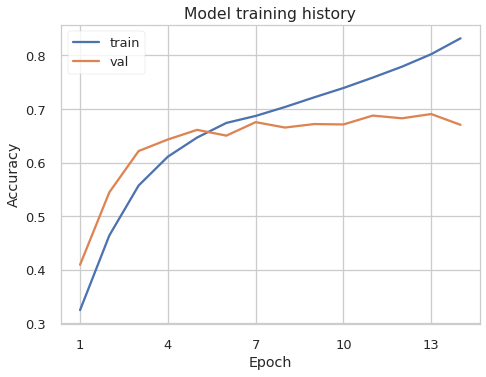

In [ ]:
plt.figure(figsize=(7.5,5.5))
plt.plot(history10.history['accuracy'])
plt.plot(history10.history['val_accuracy'])
plt.title('Model training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, len(history10.history.get("accuracy"))+1, 3), 
           labels = [str(i+1) for i in np.arange(0, len(history10.history.get("accuracy"))+1, 3)])
plt.title('Model training history')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

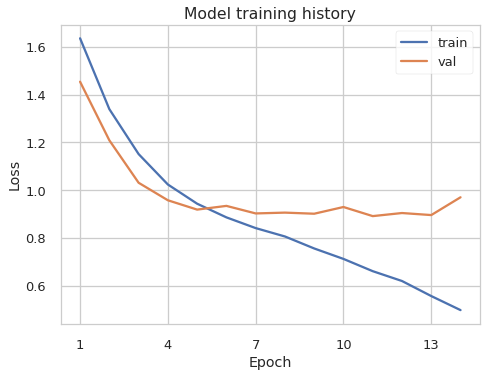

In [ ]:
plt.figure(figsize=(7.5,5.5))
plt.plot(history10.history['loss'])
plt.plot(history10.history['val_loss'])
plt.title('Model training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, len(history10.history.get("loss"))+1, 3), 
           labels = [str(i+1) for i in np.arange(0, len(history10.history.get("loss"))+1, 3)])
plt.title('Model training history')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
results10 = model10.predict(x = x_test, batch_size=64, verbose=0)
predictions10 = np.argmax(results10, axis=1)

y_test_labels = np.argmax(y_test, axis=1)
print(metrics.classification_report(y_test_labels, predictions10, digits = 3)) 

              precision    recall  f1-score   support

           0      0.764     0.557     0.645       400
           1      0.633     0.775     0.697       383
           2      0.514     0.457     0.484       162
           3      0.655     0.587     0.619       281
           4      0.574     0.745     0.648       239
           5      0.564     0.550     0.557        80

    accuracy                          0.635      1545
   macro avg      0.617     0.612     0.608      1545
weighted avg      0.646     0.635     0.632      1545



In [ ]:
# save keras model
model10.save("/content/drive/MyDrive/Colab Notebooks/reddit_IAA/PaREMO_model.h5")

In [ ]:
# load model for later use
model10 = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/reddit_IAA/PaREMO_model.h5")

In [ ]:
social_media.sample(3)

,Data,Tekst,predicted_emotion_label_PaREMO,sentiment_label_PaRes,Time,clean_Tekst
10497.0,2020-05-06 21:17:12,Pan Stanisław Żółtek mi się bardzo kojarzy z moim wujkiem Eustachym. Taki swój chłop.\n#debataprezydencka,joy,pos,21:17:12,pan stanisław żółtek mi się bardzo kojarzy z moim wujkiem eustachym. taki swój chłop. #debataprezydencka
3709.0,2020-05-06 21:56:34,@wsawoniewicz @RobertBiedron @przedwiosnie_ @__Lewica @wiosnabiedronia @Lewica_News @LewicowyHub Hołownia salkę katachetyczną\n\n\n\nHołownia nie ma wiele w...,surprise,neg,21:56:34,@u @u @u @u @u @u @u hołownia salkę katachetyczną hołownia nie ma wiele wspólnego z katechizmem. aleście tam odrealnieni...
13441.0,2020-05-06 21:02:59,Jak słucham @KosiniakKamysz to aż chciałbym zostać rolnikiem #debataprezydencka,anger,neg,21:02:59,jak słucham @u to aż chciałbym zostać rolnikiem #debataprezydencka


In [ ]:
x = social_media.clean_Tekst.tolist()
x[:2]

['@u w wigilie',
 '@u @u tylko do tego nadaje się to objawienie towarzyskie towarzysza jarosława: url']

In [ ]:
x = laser.embed_sentences(x, lang='pl')
x[:2]

array([[ 0.00511657,  0.00030736,  0.00237698, ...,  0.00740784,
        -0.00511049,  0.00825961],
       [ 0.01039652,  0.00765814,  0.00145784, ...,  0.04781285,
         0.02050592,  0.02041662]], dtype=float32)

In [ ]:
result_pl = model10.predict(x = x, batch_size=64, verbose=0)
labels_pl = np.argmax(result_pl, axis=1)
result_pl[:3]

array([[3.4088425e-02, 3.7957963e-01, 5.4175109e-01, 1.6622860e-02,
        2.3311121e-02, 4.6469020e-03],
       [6.0230973e-03, 9.8890531e-01, 2.9590288e-03, 7.8359887e-04,
        2.4704519e-04, 1.0818898e-03],
       [1.3126427e-01, 3.3764276e-01, 5.5965362e-03, 6.5520242e-02,
        4.2155206e-01, 3.8424101e-02]], dtype=float32)

In [ ]:
labels_pl[:3]

array([2, 1, 4])

In [ ]:
social_media['emotion'] = labels_pl
social_media['emotion'] = social_media['emotion'].map(map_emo)
social_media['emotion'].value_counts()

joy         8427
fear        3740
anger       3342
sadness     3105
surprise     253
love         206
Name: emotion, dtype: int64

In [ ]:
social_media.sample(4)

,Data,Tekst,predicted_emotion_label_PaREMO,sentiment_label_PaRes,Time,clean_Tekst,emotion
4356.0,2020-05-06 21:51:00,@RobertKwit5 Niet waar! Głownia i Biedroń. Tak będzie w sondażach. Po Dudzie.,surprise,neg,21:51:00,@u niet waar! głownia i biedroń. tak będzie w sondażach. po dudzie.,anger
9596.0,2020-05-06 21:21:14,@LukaszBok Brak udziału ludzi zwiększa przewagę @AndrzejDuda,surprise,neg,21:21:14,@u brak udziału ludzi zwiększa przewagę @u,sadness
15667.0,2020-05-06 20:50:29,"Jakubiak wygląda jak ojciec chrzestny, Tanajlo jak DJ Adamus a Żółtek wyglada jakby se strzelił 0.5L... #debataprezydencka",surprise,neg,20:50:29,"jakubiak wygląda jak ojciec chrzestny, tanajlo jak dj adamus a żółtek wyglada jakby se strzelił . l... #debataprezydencka",surprise
10328.0,2020-05-06 21:18:10,"Unia stoi na Francji i Niemczech, wiec bardzo logiczne wydaje się to, co mówiła Kidawa - Trójkąt Weimarski reaktywacja! #debataprezydencka #debata",surprise,neg,21:18:10,"unia stoi na francji i niemczech, wiec bardzo logiczne wydaje się to, co mówiła kidawa - trójkąt weimarski reaktywacja! #debataprezydencka #debata",fear


####emotion detection - fine-tune BERT

In [ ]:
int(dummy_y.shape[1])

6

In [ ]:
!pip install transformers[sentencepiece] --q

In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

checkpoint = "bert-base-multilingual-uncased" 

tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = int(dummy_y.shape[1])) 

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/999M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.config

BertConfig {
  "_name_or_path": "bert-base-multilingual-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_versi

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, dummy_y, test_size = 0.15, random_state = 3)

x_train.shape, x_test.shape

((13125,), (2317,))

In [ ]:
x_train[:2]

array(['i feel fairly calm',
       'i feel vital full of energy every day and super positive'],
      dtype=object)

In [ ]:
max_len = data.clean_text.str.split().map(len).max()
max_len

64

In [ ]:
x_train = tokenizer(text = list(x_train),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = list(x_test), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
x_train

{'input_ids': <tf.Tensor: shape=(13125, 64), dtype=int32, numpy=
array([[  101,   151, 23333, ...,     0,     0,     0],
       [  101,   151, 23333, ...,     0,     0,     0],
       [  101,   151, 10345, ...,     0,     0,     0],
       ...,
       [  101,   151, 23333, ...,     0,     0,     0],
       [  101,   151, 11821, ...,     0,     0,     0],
       [  101, 10205, 35260, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(13125, 64), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
model.layers

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  167356416 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
Total params: 167,361,030
Trainable params: 167,361,030
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy

optimizer = Adam(learning_rate = 3e-5, decay = 1e-2, )
loss = CategoricalCrossentropy(from_logits = True) 
metric = CategoricalAccuracy('accuracy')

model.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = y_train, 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       y_test), 
                    epochs = 1, 
                    batch_size = 8, verbose = 1)

1641/1641 [==============================] - 331s 188ms/step - loss: 0.4553 - accuracy: 0.8523 - val_loss: 0.2366 - val_accuracy: 0.9202


In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})
softmax_labels = tf.nn.softmax(predicted[0])
labels_bert = np.argmax(softmax_labels, axis = -1)
labels_bert[:3]

73/73 [==============================] - 13s 141ms/step


array([4, 0, 1])

In [ ]:
predicted[:3]

(array([[-2.8345682e-02, -1.5518136e+00, -1.9618503e+00,  4.2511734e-01,
          4.4837155e+00, -1.1730553e-01],
        [ 4.5353174e+00, -5.3360045e-01, -1.2751302e+00, -1.1821263e+00,
         -1.7217901e-01, -1.5852916e+00],
        [-9.4194275e-01,  4.5152688e+00, -5.3920662e-01, -1.1763372e+00,
         -1.4901637e+00, -8.3353740e-01],
        ...,
        [-3.6998424e-01, -1.0015520e+00, -1.8713619e+00, -4.1280335e-01,
          4.4616089e+00,  3.0436808e-01],
        [-1.3977872e+00,  4.2024531e+00,  6.6696334e-04, -1.4834522e+00,
         -1.6447107e+00,  1.4668645e-01],
        [-1.0223975e+00,  4.3575721e+00,  2.5367537e-01, -1.5895456e+00,
         -2.0464709e+00, -7.2019356e-01]], dtype=float32),)

In [ ]:
y_test[:3]

array([[0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
map_emo

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [ ]:
print(metrics.classification_report(np.argmax(y_test, axis = -1), labels_bert, digits=3)) 

              precision    recall  f1-score   support

           0      0.936     0.954     0.945       586
           1      0.966     0.891     0.927       599
           2      0.825     0.948     0.882       229
           3      0.961     0.906     0.933       435
           4      0.881     0.938     0.908       354
           5      0.821     0.842     0.831       114

    accuracy                          0.920      2317
   macro avg      0.898     0.913     0.904      2317
weighted avg      0.923     0.920     0.921      2317



In [ ]:
sequence = social_media.sample(10).clean_Tekst.tolist()
sequence

['dziwny ten zegar #debataprezydencka',
 '@u @u prędzej kosmici wylądują przed sejmem niż ta pacynka zostanie prezydentem url',
 'ty biedroń,jeśli ratownik zarabia poniżej url chyba pracuje na  /  etatu. #debataprezydencka',
 'buraku. pan andrzej to pan prezydent! wyjątkowa kanalia jesteś buraku! #debataprezydencka url',
 '@u @u @u @u @u @u mnie to nie dziwi',
 '#debataprezydencka potrzebne są pieniądze obrotowe - to dobry pomysł pani mkb',
 '#wyboryprezydenckie  #debataprezydencka pani kidawa. " trzeba przywrócić honor i godność oficerom " ale tylko byłym sb, ub, lwp itp. url',
 '@u #debataprezydencka potrzebujemy poważnej polityki zagranicznej, musimy rozmawiać jako partnerzy i sojusznicy. kiedy zostanę prezydentem, zaproszę do polski przywódców trójkąta weimarskiego.  #prawdziwaprezydent',
 'napewno rzad czy to tusk zaspal',
 'kandydaci na prezydenta rp zaprezentowali swoje pomysły na gospodarkę podczas debaty w tvp #wybory  #debataprezydencka url o gospodarkę wgospodarce.pl kandyda

In [ ]:
sequence_embed = tokenizer(text = sequence,
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
predicted2 = model.predict({'input_ids': sequence_embed['input_ids'], 'attention_mask': sequence_embed['attention_mask']})
softmax_labels2 = tf.nn.softmax(predicted2[0])
labels = np.argmax(softmax_labels2, axis = -1)
labels

1/1 [==============================] - 0s 95ms/step


array([1, 1, 3, 1, 0, 1, 1, 1, 0, 1])

In [ ]:
new_df = pd.DataFrame({'text':sequence, 'emotion':labels})
new_df['emotion'] = new_df['emotion'].map(map_emo)
new_df

,text,emotion
0,dziwny ten zegar #debataprezydencka,joy
1,@u @u prędzej kosmici wylądują przed sejmem niż ta pacynka zostanie prezydentem url,joy
2,"ty biedroń,jeśli ratownik zarabia poniżej url chyba pracuje na / etatu. #debataprezydencka",anger
3,buraku. pan andrzej to pan prezydent! wyjątkowa kanalia jesteś buraku! #debataprezydencka url,joy
4,@u @u @u @u @u @u mnie to nie dziwi,sadness
5,#debataprezydencka potrzebne są pieniądze obrotowe - to dobry pomysł pani mkb,joy
6,"#wyboryprezydenckie #debataprezydencka pani kidawa. "" trzeba przywrócić honor i godność oficerom "" ale tylko byłym sb, ub, lwp itp. url",joy
7,"@u #debataprezydencka potrzebujemy poważnej polityki zagranicznej, musimy rozmawiać jako partnerzy i sojusznicy. kiedy zostanę prezydentem, zaproszę do pols...",joy
8,napewno rzad czy to tusk zaspal,sadness
9,kandydaci na prezydenta rp zaprezentowali swoje pomysły na gospodarkę podczas debaty w tvp #wybory #debataprezydencka url o gospodarkę wgospodarce.pl kandy...,joy


##join data

In [ ]:
def process_reactions(dataframe_social_media, dataframe_debate, analysis_type = "sentiment"):
  """
  time shift = -1min;
  
  dataframe_social_media: data with social media reactions (comments), 

  dataframe_debate: data with debate arguments, 
  
  analysis_type: 'sentiment' or 'emotions', 

  """
  sm_data = dataframe_social_media.copy()
  deb_data = dataframe_debate.copy()

  sm_data.sort_values(by = 'Data', inplace=True)

  deb_data["Time"] = pd.to_datetime(deb_data.start)
  deb_data.sort_values(by = "Time", inplace=True)

  df_plot = deb_data.set_index("Time").resample("1T").mean().fillna(0)
  df_plot.reset_index(inplace=True)
  df_plot["Time"] = df_plot["Time"].dt.time.apply(str)

  if analysis_type == "emotion":
    df_plots_counts_normalized = pd.DataFrame(sm_data.set_index("Data").shift(periods=-1, 
                                                                              freq="T", 
                                                                              axis=0).resample("1T")["emotion"].value_counts(normalize=True)) * 100
    df_plots_counts_normalized.columns = ['_'.join(col) for col in df_plots_counts_normalized.columns]
    df_plots_counts_normalized = df_plots_counts_normalized.reset_index()
    df_plots_counts_normalized.columns = ['Data', 'emotion', 'mean']

    df_plots_counts_normalized.sort_values(by = ['Data', 'emotion'], inplace=True)
    df_plots_counts_normalized["Time"] = df_plots_counts_normalized["Data"].dt.time.apply(str)

    # merge social media and debate data
    df_plot_join = pd.merge(df_plots_counts_normalized, df_plot, on = "Time", how = "left")

    # additionally we can take only selected columns
    #emotions = ['Anger', 'Sadness', 'Fear', 'Disgust', 'Happiness']
    #cols = [c for c in df_plot_join.columns for i, n in enumerate(emotions) if emotions[i] in c] 


  else:
    df_plots_counts_normalized = pd.DataFrame(sm_data.set_index("Data").shift(periods=-1, 
                                                                              freq="T", 
                                                                              axis=0).resample("1T")["sentiment_label_PaRes"].value_counts(normalize=True)) * 100
    df_plots_counts_normalized.columns = ['_'.join(col) for col in df_plots_counts_normalized.columns]
    df_plots_counts_normalized = df_plots_counts_normalized.reset_index()
    df_plots_counts_normalized.columns = ['Data', 'sentiment_label_PaRes', 'mean']

    df_plots_counts_normalized.sort_values(by = ['Data', 'sentiment_label_PaRes'], inplace=True)
    df_plots_counts_normalized["Time"] = df_plots_counts_normalized["Data"].dt.time.apply(str)
    
    # merge social media and debate data
    df_plot_join = pd.merge(df_plots_counts_normalized, df_plot, on = "Time", how = "left")

  return df_plot_join

In [ ]:
df_corr_pl_processed = process_reactions(dataframe_social_media = social_media, 
                                        dataframe_debate = df, 
                                        analysis_type = 'emotion') # sentiment  emotion

# take data only from the time of the live debate
may_data = df_corr_pl_processed[ (df_corr_pl_processed.Data >= '2020-05-06 20:34:00') & (df_corr_pl_processed.Data <= '2020-05-06 21:42:00') ]
june_data = df_corr_pl_processed[ (df_corr_pl_processed.Data >= '2020-06-17 21:03:00') & (df_corr_pl_processed.Data <= '2020-06-17 22:18:00') ]


df_corr_pl_processed = may_data 
print(df_corr_pl_processed.shape, '\n')
df_corr_pl_processed.head(3)

(395, 50) 



,Data,emotion,mean,Time,question number,conclusion_valence_score,conclusion_valence_positive_count,conclusion_valence_negative_count,conclusion_joy,conclusion_anger,conclusion_sadness,conclusion_fear,conclusion_disgust,conclusion_valence,conclusion_arousal,conclusion_CATEGORY_HAP,conclusion_CATEGORY_FEA,conclusion_CATEGORY_SAD,conclusion_CATEGORY_ANG,conclusion_CATEGORY_DIS,premise_valence_score,premise_valence_positive_count,premise_valence_negative_count,premise_joy,premise_anger,premise_sadness,premise_fear,premise_disgust,premise_valence,premise_arousal,premise_CATEGORY_ANG,premise_CATEGORY_HAP,premise_CATEGORY_FEA,premise_CATEGORY_SAD,premise_CATEGORY_DIS,full_argument_valence_score,full_argument_valence_positive_count,full_argument_valence_negative_count,full_argument_joy,full_argument_anger,full_argument_sadness,full_argument_fear,full_argument_disgust,full_argument_valence,full_argument_arousal,full_argument_CATEGORY_HAP,full_argument_CATEGORY_ANG,full_argument_CATEGORY_FEA,full_argument_CATEGORY_SAD,full_argument_CATEGORY_DIS
26,2020-05-06 20:34:00,anger,16.129032,20:34:00,1.0,0.267857,0.333333,1.333333,0.252333,0.1,0.199,0.0,0.075667,0.472,0.557333,0.0,0.0,0.333333,0.333333,0.0,0.275,1.0,0.333333,0.0,0.0,0.597,0.0,0.0,0.29,0.524,0.0,0.0,0.0,0.333333,0.0,0.259259,1.333333,1.666667,0.126333,0.1,0.298667,0.0,0.075667,0.383667,0.538667,0.0,0.333333,0.0,0.666667,0.0
27,2020-05-06 20:34:00,fear,32.258065,20:34:00,1.0,0.267857,0.333333,1.333333,0.252333,0.1,0.199,0.0,0.075667,0.472,0.557333,0.0,0.0,0.333333,0.333333,0.0,0.275,1.0,0.333333,0.0,0.0,0.597,0.0,0.0,0.29,0.524,0.0,0.0,0.0,0.333333,0.0,0.259259,1.333333,1.666667,0.126333,0.1,0.298667,0.0,0.075667,0.383667,0.538667,0.0,0.333333,0.0,0.666667,0.0
28,2020-05-06 20:34:00,joy,38.709677,20:34:00,1.0,0.267857,0.333333,1.333333,0.252333,0.1,0.199,0.0,0.075667,0.472,0.557333,0.0,0.0,0.333333,0.333333,0.0,0.275,1.0,0.333333,0.0,0.0,0.597,0.0,0.0,0.29,0.524,0.0,0.0,0.0,0.333333,0.0,0.259259,1.333333,1.666667,0.126333,0.1,0.298667,0.0,0.075667,0.383667,0.538667,0.0,0.333333,0.0,0.666667,0.0


In [ ]:
df_corr_pl_processed = df_corr_pl_processed.reset_index(drop=True)

In [ ]:
# simple filter forcols with numerical values
df_corr_pl_processed.describe().columns

##correlation

In [ ]:
eliciting_emo = df_corr_pl_processed.describe().columns

In [ ]:
# optional:  apply logarithmic transformation to the calculated proportions of emotions

df_corr_pl_processed['mean'] = df_corr_pl_processed['mean'].apply(lambda x: np.log(x+1))

for c in eliciting_emo:
  df_corr_pl_processed[c] = df_corr_pl_processed[c].apply(lambda x: np.log((x+1))

In [ ]:
emo = df_corr_pl_processed.emotion.unique()
emo

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)

In [ ]:
df_corr_pl_processed[(df_corr_pl_processed[['full_argument_valence_positive_count', 
                                            'full_argument_valence_negative_count', 
                                            'full_argument_valence']].any(axis=1))].shape

(321, 50)

In [ ]:
df_corr_pl_processed.shape

(395, 50)

###calculate coefficients

In [ ]:
from scipy.stats import pearsonr, spearmanr

In [ ]:
one = []
second = []
corcof = []
pvals = []

for e_exp in emo:
  df_cor = df_corr_pl_processed[ (df_corr_pl_processed.emotion == e_exp) & \
                                (df_corr_pl_processed[['full_argument_valence_positive_count', 
                                                       'full_argument_valence_negative_count', 
                                                       'full_argument_valence']].any(axis=1)) ]
  for e_el in eliciting_emo:
    sample_exp = df_cor['mean'].values
    sample_elicit = df_cor[e_el].values
    print(f"Exp: {e_exp} - El: {e_el} ")
    coef, pval = pearsonr(sample_exp, sample_elicit)
    coef_spear, pval_spear = spearmanr(sample_exp, sample_elicit)
    print('Spearman ', round(coef_spear, 2), round(pval_spear, 3))
    print('Pearson ', round(coef, 2), round(pval, 3))
    if pval <= 0.05:
      print("\nH0 could be rejected !! \n")
    print("\n")
    one.append(e_exp)
    second.append(e_el)
    corcof.append(round(coef, 3))
    pvals.append(round(pval, 3))


In [ ]:
df_res = pd.DataFrame({"first_emotion": second, 
                       "second_emotion": one, 
                       "cor": corcof, 
                       "p_value":pvals})
df_res.head(2)

In [ ]:
df_res[df_res.p_value <= 0.05].sort_values(by = 'first_emotion') 

###plots

In [ ]:
df_plot = df_res[df_res.p_value <= 0.05].sort_values(by='first_emotion').reset_index(drop=True)

###lineplot

####rolling average

In [ ]:
ids = [2,3,4,6,7,8,9,10] # select emotions

In [ ]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html
# Moving average (with window = 3)

for i in ids:
  expr = df_plot.loc[i, 'second_emotion']
  elicit = df_plot.loc[i, 'first_emotion']

  data = df_corr_pl_processed[ (df_corr_pl_processed.emotion == expr) &\
                            (df_corr_pl_processed[['full_argument_valence_positive_count', 'full_argument_valence_negative_count', 'full_argument_valence']].any(axis=1))]

  data['exp'] = (data['mean'] / data['mean'].mean())
  data['eliciting'] = (data[elicit] / data[elicit].mean())
  data2 = data[['Time', 'exp', 'eliciting']].rolling(3).mean().iloc[2:]

  print('EX:', expr, " EL:", elicit, "coeff: ", df_plot.loc[i, 'cor'])
  plt.figure(figsize=(14, 7))
  plt.plot(data.loc[data2.index, 'Time'], data2['exp'], color='red', label='expressed')
  plt.plot(data.loc[data2.index, 'Time'], data2['eliciting'], color='black', label = 'eliciting')
  plt.xticks(rotation=90, fontsize=10)
  plt.legend(loc='best')
  plt.show()
  print('\n\n')

###barplot

####normal 

In [ ]:
for i in ids:
  expr = df_plot.loc[i, 'second_emotion']
  elicit = df_plot.loc[i, 'first_emotion']

  data = df_corr_pl_processed[ (df_corr_pl_processed.emotion == expr) &\
                            (df_corr_pl_processed[['full_argument_valence']].any(axis=1))]

  data['exp'] = (data['mean'] / data['mean'].mean())
  data['eliciting'] = (data[elicit] / data[elicit].mean())

  print('EX:', expr, " EL:", elicit, "coeff: ", df_plot.loc[i, 'cor'])
  plt.figure(figsize=(12, 6))
  plt.bar(data['Time'], data['exp'], color='red', label='expressed', alpha=0.8)
  plt.plot(data['Time'], data['eliciting'], color='black', label = 'eliciting', linewidth=2.5)
  plt.xticks(rotation=90, fontsize=10)
  plt.legend(loc='best')
  #plt.ylabel('')
  plt.show()

  print('\n\n')

####rolling average

In [ ]:
# barplot with rolling average (3)

for i in ids:
  expr = df_plot.loc[i, 'second_emotion']
  elicit = df_plot.loc[i, 'first_emotion']

  data = df_corr_pl_processed[ (df_corr_pl_processed.emotion == expr) &\
                            (df_corr_pl_processed[['full_argument_valence']].any(axis=1))]

  data['exp'] = (data['mean'] / data['mean'].mean())
  data['eliciting'] = (data[elicit] / data[elicit].mean())
  data2 = data[['Time', 'exp', 'eliciting']].rolling(3).mean().iloc[2:]

  print('EX:', expr, " EL:", elicit, "coeff: ", df_plot.loc[i, 'cor'])

  plt.figure(figsize=(12, 6))
  plt.bar(data.loc[data2.index, 'Time'], data2['exp'], color='red', label='expressed', alpha=0.8)
  plt.plot(data.loc[data2.index, 'Time'], data2['eliciting'], color='black', label = 'eliciting', linewidth=2.5)
  plt.xticks(rotation=90, fontsize=10)
  plt.legend(loc='best')
  plt.show()
  print('\n\n')

##Add arg schemes

In [ ]:
arg = load_data('/content/drive/MyDrive/Colab Notebooks/debates/Argument_schemes/agg_dummies_fleiss_all_maps.xlsx')
print(arg.shape)
arg.head(1)

(529, 10)


,conclusion,premise,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Default Inference,scheme_name_Fear Appeal,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences,scheme_name_Waste
0,I just went to a wedding of a friend of mine who happens to be gay,"if somebody doesn't think the way KASICH does, it doesn't mean that KASICH can't care about them or can't love them",0,0,0,0,0,0,5,0


In [ ]:
schems = ['scheme_name_Causal Slippery Slope', 'scheme_name_Danger Appeal',
       'scheme_name_Fear Appeal', 'scheme_name_Need For Help', 'scheme_name_Negative Consequences',
       'scheme_name_Positive Consequences', 'scheme_name_Waste', 'scheme_name_Default Inference']

In [ ]:
# here !!
arg = arg[['conclusion', 'premise', 'scheme_name_Causal Slippery Slope','scheme_name_Danger Appeal','scheme_name_Fear Appeal', 'scheme_name_Need For Help',
       'scheme_name_Negative Consequences','scheme_name_Positive Consequences', 'scheme_name_Waste', 'scheme_name_Default Inference']]
arg['schm'] = arg[schems].max(axis=1)

for s in schems:
  arg[s] = np.where(arg[s] == arg['schm'], 1, 0)

arg = arg.iloc[:, :-1]
#arg['scheme_name_Default Inference'] = np.where(arg[schems].sum(axis=1) == 2, 0, arg['scheme_name_Default Inference'])
ids = np.where(arg[schems].sum(axis=1) > 1)
maxs = arg.loc[ids].iloc[:, 2:].idxmax(axis=1).values
for n, i in enumerate(ids):
  arg.loc[i, schems] = 0
  arg.loc[i, maxs[n]] = 1

In [ ]:
arg[schems].sum(axis=1).value_counts()

1    529
dtype: int64

In [ ]:
arg.columns = ['conclusion_schemes', 'premise_schemes', 'scheme_name_Causal Slippery Slope',
       'scheme_name_Danger Appeal', 'scheme_name_Default Inference',
       'scheme_name_Fear Appeal', 'scheme_name_Need For Help',
       'scheme_name_Negative Consequences', 'scheme_name_Positive Consequences', 'scheme_name_Waste']

In [ ]:
arg2 = load_data('/content/drive/MyDrive/Colab Notebooks/debates/Argument_schemes/all_annotated_schemes_3774.xlsx')
print(arg2.shape)

(3774, 18)


In [ ]:
arg2 = arg2[['conclusion', 'premise', 'Causal Slippery Slope',
       'Danger Appeal', 'Default Inference', 'Fear Appeal', 'Need For Help',
       'Negative Consequences', 'Positive Consequences', 'Waste']]

arg2.columns = arg.columns  

In [ ]:
arg = pd.concat([arg, arg2], axis = 0)
print(arg.shape)
arg = arg.drop_duplicates(['conclusion_schemes', 'premise_schemes'], keep = 'first')
arg.shape

(4303, 10)


(1629, 10)

In [ ]:
arg.reset_index(drop=True, inplace=True)

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
id_arg = []
id_deb = []
for i in arg.index:
  for i2 in df.index:
    if (arg.loc[i, 'conclusion_schemes'].lower().strip() in df.loc[i2, 'full_argument'].lower()) and (arg.loc[i, 'premise_schemes'].lower().strip() in df.loc[i2, 'full_argument'].lower()):
      id_arg.append(i)
      id_deb.append(i2)

len(id_arg), len(id_deb)

(207, 207)

In [ ]:
argmatched = arg.loc[id_arg]
argmatched.reset_index(drop=True, inplace=True)

debmatched = df.loc[id_deb]
debmatched.reset_index(drop=True, inplace=True)

dfmatched = pd.concat([argmatched, debmatched], axis = 1)

In [ ]:
dfmatched = dfmatched.reset_index(drop=True)
dfmatched.shape

(207, 123)

In [ ]:
dfmatched = dfmatched.drop_duplicates()
dfmatched.shape

(207, 123)

In [ ]:
dfm = dfmatched.copy()
dfm.shape

(207, 123)

In [ ]:
dfm.sample(1)

,conclusion_schemes,premise_schemes,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Fear Appeal,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences,scheme_name_Waste,scheme_name_Default Inference,conclusion,premise,conclusion_lemmatized,premise_lemmatized,full_argument,full_argument_lemmatized,speaker,text,text_L,question,question number,start,end,mean_neg,mean_pos,mean_neu,conclusion_emotive_words,conclusion_Happiness,conclusion_Anger,conclusion_Sadness,conclusion_Fear,conclusion_Disgust,conclusion_Valence,conclusion_Arousal,conclusion_Happiness_individual_values,conclusion_Anger_individual_values,conclusion_Sadness_individual_values,conclusion_Fear_individual_values,conclusion_Disgust_individual_values,conclusion_Valence_individual_values,conclusion_Arousal_individual_values,conclusion_emotion_categories,conclusion_CATEGORY_nan,conclusion_CATEGORY_HAP,conclusion_CATEGORY_SAD,conclusion_CATEGORY_FEA,conclusion_CATEGORY_ANG,conclusion_CATEGORY_DIS,conclusion_CATEGORY_NEU,premise_emotive_words,premise_Happiness,premise_Anger,premise_Sadness,premise_Fear,premise_Disgust,premise_Valence,premise_Arousal,premise_Happiness_individual_values,premise_Anger_individual_values,premise_Sadness_individual_values,premise_Fear_individual_values,premise_Disgust_individual_values,premise_Valence_individual_values,premise_Arousal_individual_values,premise_emotion_categories,premise_CATEGORY_nan,premise_CATEGORY_FEA,premise_CATEGORY_HAP,premise_CATEGORY_ANG,premise_CATEGORY_DIS,premise_CATEGORY_SAD,premise_CATEGORY_NEU,full_argument_emotive_words,full_argument_Happiness,full_argument_Anger,full_argument_Sadness,full_argument_Fear,full_argument_Disgust,full_argument_Valence,full_argument_Arousal,full_argument_Happiness_individual_values,full_argument_Anger_individual_values,full_argument_Sadness_individual_values,full_argument_Fear_individual_values,full_argument_Disgust_individual_values,full_argument_Valence_individual_values,full_argument_Arousal_individual_values,full_argument_emotion_categories,full_argument_CATEGORY_nan,full_argument_CATEGORY_FEA,full_argument_CATEGORY_HAP,full_argument_CATEGORY_ANG,full_argument_CATEGORY_SAD,full_argument_CATEGORY_DIS,full_argument_CATEGORY_NEU,conclusion_valence_score,conclusion_valence_negative,conclusion_valence_positive,conclusion_Valence_negative_standardized,conclusion_Valence_positive_standardized,conclusion_Valence_standardized,conclusion_Negative_percentage,conclusion_Positive_percentage,conclusion_valence_words,premise_valence_score,premise_valence_negative,premise_valence_positive,premise_Valence_negative_standardized,premise_Valence_positive_standardized,premise_Valence_standardized,premise_Negative_percentage,premise_Positive_percentage,premise_valence_words,full_argument_valence_score,full_argument_valence_negative,full_argument_valence_positive,full_argument_Valence_negative_standardized,full_argument_Valence_positive_standardized,full_argument_Valence_standardized,full_argument_Negative_percentage,full_argument_Positive_percentage,full_argument_valence_words,Time
145,"to pokazuje, że te dwie główne partie wspierają integrację europejską poza obszarami, o których się dyskutuje w świecie publicznym",Platforma Obywatelska tego nie kontestuje,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"to pokazuje, że te dwie główne partie wspierają integrację europejską poza obszarami, o których się dyskutuje w świecie publicznym","Platforma Obywatelska tego nie kontestuje prezydent Andrzej Duda chwalił się, że to jego list sprawił, że ten nowy instrument zadłużania całej Unii Europejskiej jest tworzony stworzenia nowego instrumentu, którego euro Karaczi chcieli przez lata i nigdy nie mieli","['to', 'pokazywać', 'że', 'te', 'dwa', 'główny', 'partia', 'wspierać', 'integracja', 'europejski', 'poza', 'obszar', 'których', 'się', 'dyskutować', 'świat', 'publiczny']","['platforma', 'obywatelski', 'tego', 'nie', 'kontestować', 'prezydent', 'andrzej', 'duda', 'chw

In [ ]:
dfm_uniq = dfm.groupby(['conclusion', 'premise'], as_index = False)[schems].sum() 
dfm_uniq.shape

(147, 10)

In [ ]:
dfm_uniq.tail(2)

,conclusion,premise,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Fear Appeal,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences,scheme_name_Waste,scheme_name_Default Inference
145,"środki będą sprawiały, że w końcu będziemy mieli rozwiązane te wszystkie kwestie","to są realne środki, które powinny trafić do Polski na budowę tanich mieszkań, na wynajem dwa miliony paneli fotowoltaicznych",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
146,"żaden z imigrantów nie ma prawa do zasiłków, socjali ani darmowych usług","brak dostępu do zasiłków, socjali i darmowych usług spowoduje, że nie będą tu się się pchały darmozjady i ci, którzy chcą na zasiłkach żyć",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df = df.merge(dfm_uniq, on = ['conclusion', 'premise'], how = 'left')

In [ ]:
df.shape

(150, 121)

In [ ]:
df[schems].describe()

,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Fear Appeal,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences,scheme_name_Waste,scheme_name_Default Inference
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.0,148.000000
mean,0.013514,0.074324,0.027027,0.135135,0.202703,0.385135,0.0,0.574324
std,0.115852,0.310611,0.259407,0.475933,0.627699,0.704926,0.0,0.710382
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.000000
max,1.000000,2.000000,3.000000,3.000000,6.000000,4.000000,0.0,3.000000


In [ ]:
df = df[df[schems].any(axis=1)]

In [ ]:
df.start.nunique()

60

####Process reactions

**Emotion analysis**

In [ ]:
# change date and take only time of a debate
# May:  (df_corr_pl_processed.Data >= '2020-05-06 20:34:00') & (df_corr_pl_processed.Data <= '2020-05-06 21:42:00')
# June:  (df_corr_pl_processed.Data >= '2020-06-17 21:03:00') & (df_corr_pl_processed.Data <= '2020-06-17 22:18:00') 


df_corr_pl_processed = process_reactions_nobase_both(dataframe_social_media = social_media, 
                                        dataframe_debate = df, 
                                        analysis_type = 'emotion') # sentiment  emotion

may_data = df_corr_pl_processed[ (df_corr_pl_processed.Data >= '2020-05-06 20:34:00') & (df_corr_pl_processed.Data <= '2020-05-06 21:42:00') ]
june_data = df_corr_pl_processed[ (df_corr_pl_processed.Data >= '2020-06-17 21:03:00') & (df_corr_pl_processed.Data <= '2020-06-17 22:18:00') ]


df_corr_pl_processed = june_data # june_data may_data
print(df_corr_pl_processed.shape, '\n')
df_corr_pl_processed.head(3)

(413, 82) 



,Data,predicted_emotion_label_PaREMO,mean,Time,question number,mean_neg,mean_pos,mean_neu,conclusion_Happiness,conclusion_Anger,conclusion_Sadness,conclusion_Fear,conclusion_Disgust,conclusion_Valence,conclusion_Arousal,conclusion_CATEGORY_nan,conclusion_CATEGORY_HAP,conclusion_CATEGORY_SAD,conclusion_CATEGORY_FEA,conclusion_CATEGORY_ANG,conclusion_CATEGORY_DIS,conclusion_CATEGORY_NEU,premise_Happiness,premise_Anger,premise_Sadness,premise_Fear,premise_Disgust,premise_Valence,premise_Arousal,premise_CATEGORY_nan,premise_CATEGORY_FEA,premise_CATEGORY_HAP,premise_CATEGORY_ANG,premise_CATEGORY_DIS,premise_CATEGORY_SAD,premise_CATEGORY_NEU,full_argument_Happiness,full_argument_Anger,full_argument_Sadness,full_argument_Fear,full_argument_Disgust,full_argument_Valence,full_argument_Arousal,full_argument_CATEGORY_nan,full_argument_CATEGORY_FEA,full_argument_CATEGORY_HAP,full_argument_CATEGORY_ANG,full_argument_CATEGORY_SAD,full_argument_CATEGORY_DIS,full_argument_CATEGORY_NEU,conclusion_valence_score,conclusion_valence_negative,conclusion_valence_positive,conclusion_Valence_negative_standardized,conclusion_Valence_positive_standardized,conclusion_Valence_standardized,conclusion_Negative_percentage,conclusion_Positive_percentage,premise_valence_score,premise_valence_negative,premise_valence_positive,premise_Valence_negative_standardized,premise_Valence_positive_standardized,premise_Valence_standardized,premise_Negative_percentage,premise_Positive_percentage,full_argument_valence_score,full_argument_valence_negative,full_argument_valence_positive,full_argument_Valence_negative_standardized,full_argument_Valence_positive_standardized,full_argument_Valence_standardized,full_argument_Negative_percentage,full_argument_Positive_percentage,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Fear Appeal,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences,scheme_name_Waste,scheme_name_Default Inference
21,2020-06-17 21:03:00,anger,34.857143,21:03:00,1.0,33.333333,33.333333,33.333333,0.28984,0.03937,0.0,0.089045,0.0,0.623395,0.40467,1.333333,0.0,0.0,0.333333,0.0,0.0,0.0,0.226667,0.020473,0.0,0.07582,0.045313,0.580707,0.413097,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.234103,0.032057,0.0,0.066417,0.03776,0.587107,0.391063,4.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.514,0.0,0.5,0.0,0.772884,0.514,0.0,0.0335,0.436148,1.0,0.666667,0.297596,1.023432,0.436148,0.038333,0.043,0.491677,1.0,1.0,0.297596,1.0427,0.491677,0.024333,0.028333,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.666667
22,2020-06-17 21:03:00,disgust,0.571429,21:03:00,1.0,33.333333,33.333333,33.333333,0.28984,0.03937,0.0,0.089045,0.0,0.623395,0.40467,1.333333,0.0,0.0,0.333333,0.0,0.0,0.0,0.226667,0.020473,0.0,0.07582,0.045313,0.580707,0.413097,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.234103,0.032057,0.0,0.066417,0.03776,0.587107,0.391063,4.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.514,0.0,0.5,0.0,0.772884,0.514,0.0,0.0335,0.436148,1.0,0.666667,0.297596,1.023432,0.436148,0.038333,0.043,0.491677,1.0,1.0,0.297596,1.0427,0.491677,0.024333,0.028333,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.666667
23,2020-06-17 21:03:00,fear,11.428571,21:03:00,1.0,33.333333,33.333333,33.333333,0.28984,0.03937,0.0,0.089045,0.0,0.623395,0.40467,1.333333,0.0,0.0,0.333333,0.0,0.0,0.0,0.226667,0.020473,0.0,0.07582,0.045313,0.580707,0.413097,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.234103,0.032057,0.0,0.066417,0.03776,0.587107,0.391063,4.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.514,0.0,0.5,0.0,0.772884,0.514,0.0,0.0335,0.436148,1.0,0.666667,0.297596,1.023432,0.436148,0.038333,0.043,0.491677,1.0,1.0,0.297596,1.0427,0.491677,0.024333,0.028333,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.666667


In [ ]:
schems

['scheme_name_Causal Slippery Slope',
 'scheme_name_Danger Appeal',
 'scheme_name_Fear Appeal',
 'scheme_name_Need For Help',
 'scheme_name_Negative Consequences',
 'scheme_name_Positive Consequences',
 'scheme_name_Waste',
 'scheme_name_Default Inference']

In [ ]:
df_corr_pl_processed = df_corr_pl_processed[df_corr_pl_processed[schems].any(axis=1)]
df_corr_pl_processed.shape

(322, 82)

####Biserial correlation scheme - social media response

In [ ]:
df_corr_pl_processed['mean'] = df_corr_pl_processed['mean'].apply(lambda x: np.log(x+1))

In [ ]:
for s in schems:
  df_corr_pl_processed[s] = np.where(df_corr_pl_processed[s] > 0, 1, 0)

In [ ]:
df_corr_pl_processed[schems].head(3)

,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Fear Appeal,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences,scheme_name_Waste,scheme_name_Default Inference
21,0,0,0,0,0,1,0,1
22,0,0,0,0,0,1,0,1
23,0,0,0,0,0,1,0,1


In [ ]:
df_corr_pl_processed[schems].describe()

,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Fear Appeal,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences,scheme_name_Waste,scheme_name_Default Inference
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.0,322.000000
mean,0.031056,0.114907,0.031056,0.201863,0.329193,0.521739,0.0,0.658385
std,0.173739,0.319406,0.173739,0.402015,0.470651,0.500305,0.0,0.474989
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


In [ ]:
df_corr_pl_processed = df_corr_pl_processed.reset_index(drop=True)

####**Corr with positive sentiment**

In [ ]:
corr_pos = df_corr_pl_processed[df_corr_pl_processed.sentiment_label_PaRes == 'pos']
corr_pos = corr_pos.dropna(subset = ['mean'])
corr_pos.shape

(60, 82)

In [ ]:
coeffs_all = []
p_val_all = []

for s in schems:
  print(s)
  sm_response_sentiment = corr_pos['mean'].apply(float).values
  binary_scheme = corr_pos[s].apply(int).values

  coefbi, bi_p = pointbiserialr(binary_scheme, sm_response_sentiment)
  coeffs_all.append(round(coefbi, 2))
  p_val_all.append(round(bi_p, 3))

  if bi_p <= 0.05:
    print(f'{s} \t - coeff: {coefbi}:  {round(bi_p, 3)}')

scheme_name_Causal Slippery Slope
scheme_name_Danger Appeal
scheme_name_Fear Appeal
scheme_name_Need For Help
scheme_name_Negative Consequences
scheme_name_Positive Consequences
scheme_name_Waste
scheme_name_Default Inference


/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [ ]:
df_cor_bi_pos = pd.DataFrame({"scheme": schems, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_pos[df_cor_bi_pos.p_value <= 0.05] # may log new

,scheme,cor,p_value
4,scheme_name_Negative Consequences,0.28,0.037


In [ ]:
df_cor_bi_pos = pd.DataFrame({"scheme": schems, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_pos[df_cor_bi_pos.p_value <= 0.05] # june log new

,scheme,cor,p_value


####**Corr with negative sentiment**

In [ ]:
corr_neg = df_corr_pl_processed[df_corr_pl_processed.sentiment_label_PaRes == 'neg']
corr_neg = corr_neg.dropna(subset = ['mean'])

corr_neg.shape

(60, 82)

In [ ]:
coeffs_all = []
p_val_all = []

for s in schems:
  print(s)
  sm_response_sentiment = corr_neg['mean'].apply(float).values
  binary_scheme = corr_neg[s].apply(int).values

  coefbi, bi_p = pointbiserialr(binary_scheme, sm_response_sentiment)
  coeffs_all.append(round(coefbi, 2))
  p_val_all.append(round(bi_p, 4))

  if bi_p <= 0.05:
    print(f'\t{s} - coeff: {coefbi}:  {round(bi_p, 4)} \t n samples {len(sm_response_sentiment)} ')

scheme_name_Causal Slippery Slope
scheme_name_Danger Appeal
scheme_name_Fear Appeal
scheme_name_Need For Help
scheme_name_Negative Consequences
scheme_name_Positive Consequences
scheme_name_Waste
scheme_name_Default Inference


/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [ ]:
df_cor_bi_neg = pd.DataFrame({"scheme": schems, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_neg[df_cor_bi_neg.p_value <= 0.05] # may log new

,scheme,cor,p_value


In [ ]:
df_cor_bi_neg = pd.DataFrame({"scheme": schems, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_neg[df_cor_bi_neg.p_value <= 0.05] # june log new

,scheme,cor,p_value


####**Corr emotions expressed**

In [ ]:
df_corr_pl_processed.predicted_emotion_label_PaREMO.unique()

array(['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise'],
      dtype=object)

In [ ]:
from scipy.stats import pearsonr, pointbiserialr

In [ ]:
coeffs_all = []
p_val_all = []
schems_all = []
emo_all = []

for s in schems:
  print(s)
  for e in df_corr_pl_processed.predicted_emotion_label_PaREMO.unique():
    print('\t', e)
    schems_all.append(s)
    emo_all.append(e)
    corr_emo = df_corr_pl_processed[df_corr_pl_processed.predicted_emotion_label_PaREMO == e].dropna()  
    sm_response_sentiment = corr_emo['mean'].apply(float).values
    binary_scheme = corr_emo[s].apply(int).values

    coefbi, bi_p = pointbiserialr(binary_scheme, sm_response_sentiment)
    coeffs_all.append(round(coefbi, 2))
    p_val_all.append(round(bi_p, 4))

    if bi_p <= 0.05:
      print(f'{s} - {e} \t coeff: {coefbi}:  {round(bi_p, 4)}\t n samples: {len(binary_scheme)} ')

scheme_name_Causal Slippery Slope
	 anger
	 disgust
	 fear
	 joy
	 sadness
	 surprise
scheme_name_Danger Appeal
	 anger
	 disgust
	 fear
	 joy
	 sadness
	 surprise
scheme_name_Fear Appeal
	 anger
	 disgust
	 fear
	 joy
	 sadness
	 surprise
scheme_name_Need For Help
	 anger
scheme_name_Need For Help - anger 	 coeff: -0.2581631444016556:  0.0464	 n samples: 60 
	 disgust
	 fear
	 joy
	 sadness
	 surprise
scheme_name_Negative Consequences
	 anger
	 disgust
	 fear


/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


	 joy
	 sadness
	 surprise
scheme_name_Positive Consequences
	 anger
	 disgust
	 fear
	 joy
	 sadness
	 surprise
scheme_name_Waste
	 anger
	 disgust
	 fear
	 joy
	 sadness
	 surprise
scheme_name_Default Inference
	 anger
	 disgust
scheme_name_Default Inference - disgust 	 coeff: -0.483235384167369:  0.0227	 n samples: 22 
	 fear
	 joy
	 sadness
	 surprise


In [ ]:
df_cor_bi_emo = pd.DataFrame({"scheme": schems_all, 'emotion_response_sm': emo_all, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_emo[df_cor_bi_emo.p_value <= 0.05] # may log new

,scheme,emotion_response_sm,cor,p_value
20,scheme_name_Need For Help,fear,-0.33,0.0135
23,scheme_name_Need For Help,surprise,0.32,0.0168
29,scheme_name_Negative Consequences,surprise,-0.33,0.0129


In [ ]:
df_cor_bi_emo = pd.DataFrame({"scheme": schems_all, 'emotion_response_sm': emo_all, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_emo[df_cor_bi_emo.p_value <= 0.05] # june log new

,scheme,emotion_response_sm,cor,p_value
18,scheme_name_Need For Help,anger,-0.26,0.0464
43,scheme_name_Default Inference,disgust,-0.48,0.0227


#data

##join data

In [ ]:
def process_reactions(dataframe_social_media, dataframe_debate, analysis_type = "sentiment"):
  """
  time shift = -1min;
  
  dataframe_social_media: data with social media reactions (comments), 

  dataframe_debate: data with debate arguments, 
  
  analysis_type: 'sentiment' or 'emotions', 

  """
  sm_data = dataframe_social_media.copy()
  deb_data = dataframe_debate.copy()

  sm_data.sort_values(by = 'Data', inplace=True)

  deb_data["Time"] = pd.to_datetime(deb_data.start)
  deb_data.sort_values(by = "Time", inplace=True)

  df_plot = deb_data.set_index("Time").resample("1T").mean().fillna(0)
  df_plot.reset_index(inplace=True)
  df_plot["Time"] = df_plot["Time"].dt.time.apply(str)

  if analysis_type == "emotion":
    df_plots_counts_normalized = pd.DataFrame(sm_data.set_index("Data").shift(periods=-1, 
                                                                              freq="T", 
                                                                              axis=0).resample("1T")["emotion"].value_counts(normalize=True)) * 100
    df_plots_counts_normalized.columns = ['_'.join(col) for col in df_plots_counts_normalized.columns]
    df_plots_counts_normalized = df_plots_counts_normalized.reset_index()
    df_plots_counts_normalized.columns = ['Data', 'emotion', 'mean']

    df_plots_counts_normalized.sort_values(by = ['Data', 'emotion'], inplace=True)
    df_plots_counts_normalized["Time"] = df_plots_counts_normalized["Data"].dt.time.apply(str)

    # merge social media and debate data
    df_plot_join = pd.merge(df_plots_counts_normalized, df_plot, on = "Time", how = "left")

    # additionally we can take only selected columns
    #emotions = ['Anger', 'Sadness', 'Fear', 'Disgust', 'Happiness']
    #cols = [c for c in df_plot_join.columns for i, n in enumerate(emotions) if emotions[i] in c] 


  else:
    df_plots_counts_normalized = pd.DataFrame(sm_data.set_index("Data").shift(periods=-1, 
                                                                              freq="T", 
                                                                              axis=0).resample("1T")["sentiment_label_PaRes"].value_counts(normalize=True)) * 100
    df_plots_counts_normalized.columns = ['_'.join(col) for col in df_plots_counts_normalized.columns]
    df_plots_counts_normalized = df_plots_counts_normalized.reset_index()
    df_plots_counts_normalized.columns = ['Data', 'sentiment_label_PaRes', 'mean']

    df_plots_counts_normalized.sort_values(by = ['Data', 'sentiment_label_PaRes'], inplace=True)
    df_plots_counts_normalized["Time"] = df_plots_counts_normalized["Data"].dt.time.apply(str)
    
    # merge social media and debate data
    df_plot_join = pd.merge(df_plots_counts_normalized, df_plot, on = "Time", how = "left")

  return df_plot_join

In [ ]:
df_corr_pl_processed = process_reactions(dataframe_social_media = social_media, 
                                        dataframe_debate = df, 
                                        analysis_type = 'emotion') # sentiment  emotion

# take data only from the time of the live debate
may_data = df_corr_pl_processed[ (df_corr_pl_processed.Data >= '2020-05-06 20:34:00') & (df_corr_pl_processed.Data <= '2020-05-06 21:42:00') ]
june_data = df_corr_pl_processed[ (df_corr_pl_processed.Data >= '2020-06-17 21:03:00') & (df_corr_pl_processed.Data <= '2020-06-17 22:18:00') ]


df_corr_pl_processed = may_data 
print(df_corr_pl_processed.shape, '\n')
df_corr_pl_processed.head(3)

(395, 50) 



,Data,emotion,mean,Time,question number,conclusion_valence_score,conclusion_valence_positive_count,conclusion_valence_negative_count,conclusion_joy,conclusion_anger,conclusion_sadness,conclusion_fear,conclusion_disgust,conclusion_valence,conclusion_arousal,conclusion_CATEGORY_HAP,conclusion_CATEGORY_FEA,conclusion_CATEGORY_SAD,conclusion_CATEGORY_ANG,conclusion_CATEGORY_DIS,premise_valence_score,premise_valence_positive_count,premise_valence_negative_count,premise_joy,premise_anger,premise_sadness,premise_fear,premise_disgust,premise_valence,premise_arousal,premise_CATEGORY_ANG,premise_CATEGORY_HAP,premise_CATEGORY_FEA,premise_CATEGORY_SAD,premise_CATEGORY_DIS,full_argument_valence_score,full_argument_valence_positive_count,full_argument_valence_negative_count,full_argument_joy,full_argument_anger,full_argument_sadness,full_argument_fear,full_argument_disgust,full_argument_valence,full_argument_arousal,full_argument_CATEGORY_HAP,full_argument_CATEGORY_ANG,full_argument_CATEGORY_FEA,full_argument_CATEGORY_SAD,full_argument_CATEGORY_DIS
26,2020-05-06 20:34:00,anger,16.129032,20:34:00,1.0,0.267857,0.333333,1.333333,0.252333,0.1,0.199,0.0,0.075667,0.472,0.557333,0.0,0.0,0.333333,0.333333,0.0,0.275,1.0,0.333333,0.0,0.0,0.597,0.0,0.0,0.29,0.524,0.0,0.0,0.0,0.333333,0.0,0.259259,1.333333,1.666667,0.126333,0.1,0.298667,0.0,0.075667,0.383667,0.538667,0.0,0.333333,0.0,0.666667,0.0
27,2020-05-06 20:34:00,fear,32.258065,20:34:00,1.0,0.267857,0.333333,1.333333,0.252333,0.1,0.199,0.0,0.075667,0.472,0.557333,0.0,0.0,0.333333,0.333333,0.0,0.275,1.0,0.333333,0.0,0.0,0.597,0.0,0.0,0.29,0.524,0.0,0.0,0.0,0.333333,0.0,0.259259,1.333333,1.666667,0.126333,0.1,0.298667,0.0,0.075667,0.383667,0.538667,0.0,0.333333,0.0,0.666667,0.0
28,2020-05-06 20:34:00,joy,38.709677,20:34:00,1.0,0.267857,0.333333,1.333333,0.252333,0.1,0.199,0.0,0.075667,0.472,0.557333,0.0,0.0,0.333333,0.333333,0.0,0.275,1.0,0.333333,0.0,0.0,0.597,0.0,0.0,0.29,0.524,0.0,0.0,0.0,0.333333,0.0,0.259259,1.333333,1.666667,0.126333,0.1,0.298667,0.0,0.075667,0.383667,0.538667,0.0,0.333333,0.0,0.666667,0.0


In [ ]:
df_corr_pl_processed = df_corr_pl_processed.reset_index(drop=True)

In [ ]:
# simple filter forcols with numerical values
df_corr_pl_processed.describe().columns

##correlation

In [ ]:
eliciting_emo = df_corr_pl_processed.describe().columns

In [ ]:
# optional:  apply logarithmic transformation to the calculated proportions of emotions

df_corr_pl_processed['mean'] = df_corr_pl_processed['mean'].apply(lambda x: np.log(x+1))

for c in eliciting_emo:
  df_corr_pl_processed[c] = df_corr_pl_processed[c].apply(lambda x: np.log((x+1))

In [ ]:
emo = df_corr_pl_processed.emotion.unique()
emo

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)

In [ ]:
df_corr_pl_processed[(df_corr_pl_processed[['full_argument_valence_positive_count', 
                                            'full_argument_valence_negative_count', 
                                            'full_argument_valence']].any(axis=1))].shape

(321, 50)

In [ ]:
df_corr_pl_processed.shape

(395, 50)

###calculate coefficients

In [ ]:
from scipy.stats import pearsonr, spearmanr

In [ ]:
one = []
second = []
corcof = []
pvals = []

for e_exp in emo:
  df_cor = df_corr_pl_processed[ (df_corr_pl_processed.emotion == e_exp) & \
                                (df_corr_pl_processed[['full_argument_valence_positive_count', 
                                                       'full_argument_valence_negative_count', 
                                                       'full_argument_valence']].any(axis=1)) ]
  for e_el in eliciting_emo:
    sample_exp = df_cor['mean'].values
    sample_elicit = df_cor[e_el].values
    print(f"Exp: {e_exp} - El: {e_el} ")
    coef, pval = pearsonr(sample_exp, sample_elicit)
    coef_spear, pval_spear = spearmanr(sample_exp, sample_elicit)
    print('Spearman ', round(coef_spear, 2), round(pval_spear, 3))
    print('Pearson ', round(coef, 2), round(pval, 3))
    if pval <= 0.05:
      print("\nH0 could be rejected !! \n")
    print("\n")
    one.append(e_exp)
    second.append(e_el)
    corcof.append(round(coef, 3))
    pvals.append(round(pval, 3))


In [ ]:
df_res = pd.DataFrame({"first_emotion": second, 
                       "second_emotion": one, 
                       "cor": corcof, 
                       "p_value":pvals})
df_res.head(2)

In [ ]:
df_res[df_res.p_value <= 0.05].sort_values(by = 'first_emotion') 

###plots

In [ ]:
df_plot = df_res[df_res.p_value <= 0.05].sort_values(by='first_emotion').reset_index(drop=True)

###lineplot

####rolling average

In [ ]:
ids = [2,3,4,6,7,8,9,10] # select emotions

In [ ]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html
# Moving average (with window = 3)

for i in ids:
  expr = df_plot.loc[i, 'second_emotion']
  elicit = df_plot.loc[i, 'first_emotion']

  data = df_corr_pl_processed[ (df_corr_pl_processed.emotion == expr) &\
                            (df_corr_pl_processed[['full_argument_valence_positive_count', 'full_argument_valence_negative_count', 'full_argument_valence']].any(axis=1))]

  data['exp'] = (data['mean'] / data['mean'].mean())
  data['eliciting'] = (data[elicit] / data[elicit].mean())
  data2 = data[['Time', 'exp', 'eliciting']].rolling(3).mean().iloc[2:]

  print('EX:', expr, " EL:", elicit, "coeff: ", df_plot.loc[i, 'cor'])
  plt.figure(figsize=(14, 7))
  plt.plot(data.loc[data2.index, 'Time'], data2['exp'], color='red', label='expressed')
  plt.plot(data.loc[data2.index, 'Time'], data2['eliciting'], color='black', label = 'eliciting')
  plt.xticks(rotation=90, fontsize=10)
  plt.legend(loc='best')
  plt.show()
  print('\n\n')

###barplot

####normal 

In [ ]:
for i in ids:
  expr = df_plot.loc[i, 'second_emotion']
  elicit = df_plot.loc[i, 'first_emotion']

  data = df_corr_pl_processed[ (df_corr_pl_processed.emotion == expr) &\
                            (df_corr_pl_processed[['full_argument_valence']].any(axis=1))]

  data['exp'] = (data['mean'] / data['mean'].mean())
  data['eliciting'] = (data[elicit] / data[elicit].mean())

  print('EX:', expr, " EL:", elicit, "coeff: ", df_plot.loc[i, 'cor'])
  plt.figure(figsize=(12, 6))
  plt.bar(data['Time'], data['exp'], color='red', label='expressed', alpha=0.8)
  plt.plot(data['Time'], data['eliciting'], color='black', label = 'eliciting', linewidth=2.5)
  plt.xticks(rotation=90, fontsize=10)
  plt.legend(loc='best')
  #plt.ylabel('')
  plt.show()

  print('\n\n')

####rolling average

In [ ]:
# barplot with rolling average (3)

for i in ids:
  expr = df_plot.loc[i, 'second_emotion']
  elicit = df_plot.loc[i, 'first_emotion']

  data = df_corr_pl_processed[ (df_corr_pl_processed.emotion == expr) &\
                            (df_corr_pl_processed[['full_argument_valence']].any(axis=1))]

  data['exp'] = (data['mean'] / data['mean'].mean())
  data['eliciting'] = (data[elicit] / data[elicit].mean())
  data2 = data[['Time', 'exp', 'eliciting']].rolling(3).mean().iloc[2:]

  print('EX:', expr, " EL:", elicit, "coeff: ", df_plot.loc[i, 'cor'])

  plt.figure(figsize=(12, 6))
  plt.bar(data.loc[data2.index, 'Time'], data2['exp'], color='red', label='expressed', alpha=0.8)
  plt.plot(data.loc[data2.index, 'Time'], data2['eliciting'], color='black', label = 'eliciting', linewidth=2.5)
  plt.xticks(rotation=90, fontsize=10)
  plt.legend(loc='best')
  plt.show()
  print('\n\n')